This notebook estimates the number of V100 GPU-days used to train our adversaries.

Also has plots of evals over the course of adversarial fine-tuning.

In [1]:
import collections
import datetime
import os
import pprint
import re
import warnings
from pathlib import Path
from typing import Iterable, Mapping, Sequence

import dateutil.parser
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from statsmodels.stats.proportion import proportion_confint

import utils

HOURS_TO_SECONDS = 60 * 60
DAYS_TO_SECONDS = 24 * 60 * 60
# Estimate of how many V100 GPU-days is 1 A6000 GPU-day using this data:
# https://www.notion.so/chaiberkeley/Benchmark-KataGo-victimplay-on-different-hardware-295ac2d430404430b8a1e0232f72b240
# - On cp505, 3 A6000 victimplay workers generated 250k rows in 9h30m and 7
#   V100 workers generated 250k rows in 6h44m. This corresponds to an A6000 worker
#   being 1.6538x faster.
# - On cp127, 3 A6000 workers generated 1002027 rows in 16h03 and 7 V100 workers
#   generated 1019074 rows in 12h16. This corresponds to an A6000 worker being
#   1.7535x faster.
# - The mean of 1.6537 and 1.7535 is 1.7036.
#
# Comparison:
# - At https://lambdalabs.com/gpu-benchmarks with fp16 precision,
#   Lambda measures the conversion factor to be 1.48.
A6000_TO_V100_GPU_DAY = 1.703643

NAS_K8S_PATH = "/shared/nas-data/k8" # /nas/ucb/k8/go-attack if on CHAI machines
VICTIMPLAY_PATH = "/shared/victimplay"
TIME_ZONE = datetime.timezone.utc  # assume all timestamps are UTC

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Conversions to A6000 GPU-days

Our adversaries were trained using A6000, A4000, A100 40GB,
and A100 80GB GPUs. We'll estimate how many A6000 GPU-days is
1 GPU-day on each of these GPU types.

In [2]:
def get_victimplay_log_line_timestamp(line: str) -> datetime.datetime | None:
    """Fetches the timestamp from a line in a victimplay log file."""
    match = re.match(r"([0-9 \-+:]+): ", line)
    if match is None:
        return None
    return dateutil.parser.parse(match.group(1))


def get_victimplay_duration(log_filename: Path) -> float | None:
    """Returns how long the victimplay worker was generating games.

    Args:
      log_filename: Filename of the victimplay worker's log file.

    Returns:
        How long the worker was generating games in seconds.
        Returns None if the worker did not generate any games.
    """
    GAME_START_REGEX = re.compile(r"starting game")
    TIMESTAMP_REGEX = re.compile(r"([0-9 \-+:]+): ")
    with open(log_filename, "r") as f:
        first_game_start_timestamp = None
        for line in f:
            if GAME_START_REGEX.search(line) is not None:
                first_game_start_timestamp = get_victimplay_log_line_timestamp(line)
                assert first_game_start_timestamp is not None
                break
        if first_game_start_timestamp is None:
            return None

        for line in f:
            pass
        last_line = line
        last_timestamp = get_victimplay_log_line_timestamp(last_line)
        assert last_timestamp is not None
        return (last_timestamp - first_game_start_timestamp).total_seconds()


def get_victimplay_games_finished(log_filename: Path, game_limit=None) -> int:
    """Returns the number of games the victimplay worker completed.

    Args:
        log_filename: Filename of the victimplay worker's log file.
        game_limit: If not None, then stop counting and return early if
          this number of games is reached.
    """
    GAME_FINISH_REGEX = re.compile("Game #")
    num_games_finished = 0
    with open(log_filename, "r") as f:
        for line in f:
            if GAME_FINISH_REGEX.search(line) is not None:
                num_games_finished += 1
                if game_limit is not None and num_games_finished >= game_limit:
                    break
    return num_games_finished


def get_victimplay_gpu_type(log_filename: Path) -> str | None:
    """Parses GPU type from victimplay log."""
    GPU_TYPE_REGEX = re.compile(r"Found GPU (.*) memory")
    with open(log_filename, "r") as f:
        for line in f:
            match = GPU_TYPE_REGEX.search(line)
            if match is not None:
                return match.group(1)
    return None


def get_victimplay_num_gpus(log_filename: Path) -> int:
    """Parses the number of GPUs used from victimplay log."""
    GAME_START_REGEX = re.compile(r"starting game")
    GPU_INDEX_REGEX = re.compile(r"[Dd]eviceToUse[A-Za-z0-9]* = (\d+)")
    gpu_indices = set()
    with open(log_filename, "r") as f:
        for line in f:
            gpu_index_match = GPU_INDEX_REGEX.search(line)
            if gpu_index_match is not None:
                gpu_indices.add(gpu_index_match.group(1))

            if GAME_START_REGEX.search(line) is not None:
                break
    return len(gpu_indices)

In [3]:
# Victimplay runs on different GPU types with the same adversary+victim setup.
# Experiment link: https://www.notion.so/chaiberkeley/adv-s300mil-v600-vs-cp505-v8-benchmarking-by-GPU-6b151352b64241d2a67c21b6fb1c8da6
benchmarking_directories = [
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a100-40gb-20230203-163919",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a100-80gb-20230203-163757",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a4000-20230203-163607",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a6000-20230203-163319",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a100-40gb-20230206-131111",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a100-80gb-20230206-124106",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a4000-20230206-124105",
    f"{NAS_K8S_PATH}/victimplay/ttseng-bench-a6000-20230206-121545",
]

# We'll count the number of games each victimplay worker completed
# as a proxy for how performant the GPU type is for our workload.

# Key = GPU type
# Value = List of number of victimplay games per hour
#        (1 entry for each victimplay worker)
gpu_type_to_game_throughputs = collections.defaultdict(list)
for directory in benchmarking_directories:
    print(directory)
    victimplay_logfiles = Path(directory).glob(f"selfplay/log*.log")
    for logfile in victimplay_logfiles:
        assert get_victimplay_num_gpus(logfile) == 1
        duration = get_victimplay_duration(logfile)
        if duration is None:
            continue
        gpu_type = get_victimplay_gpu_type(logfile)
        assert gpu_type is not None
        games_finished = get_victimplay_games_finished(logfile)
        throughput = games_finished / (duration / HOURS_TO_SECONDS)
        gpu_type_to_game_throughputs[gpu_type].append(throughput)

gpu_type_to_avg_throughput = {}
for gpu_type, throughputs in gpu_type_to_game_throughputs.items():
    avg = np.mean(throughputs)
    stddev = np.std(throughputs)
    print(f"{gpu_type} throughput: Avg. {avg} +- {stddev}")
    gpu_type_to_avg_throughput[gpu_type] = avg

a6000_throughput = gpu_type_to_avg_throughput["NVIDIA RTX A6000"]
# Key = GPU type
# Value = Estimate of how many A6000 GPU-days is 1 GPU-day
#         of this GPU type.
gpu_type_to_a6000_gpu_days = {
    gpu_type: throughput / a6000_throughput
    for gpu_type, throughput in gpu_type_to_avg_throughput.items()
}

# Comparison points:
# - https://www.notion.so/chaiberkeley/Benchmark-KataGo-victimplay-on-different-hardware-295ac2d430404430b8a1e0232f72b240
#     1 A100 40GB GPU-day -> 1.2592 A6000 GPU-days
#
# - Eyeballing from the actual training victimplay logs in ttseng-avoid-pass-alive-coldstart-39-20221025-175949,
#   I (tomtseng) got the following numbers:
#     1 A4000 GPU-day     -> 0.6619 A6000 GPU-days
#     1 A100 40GB GPU-day -> 1.3507 A6000 GPU-days
#     1 A100 80GB GPU-day -> 1.5829 A6000 GPU-days
# - At https://lambdalabs.com/gpu-benchmarks with fp16 precision, Lambda estimates
#     1 A4000 GPU-day     -> 0.4275 A6000 GPU-days
#     1 A100 40GB GPU-day -> 1.5541 A6000 GPU-days
#     1 A100 80GB GPU-day -> 1.8378 A6000 GPU-days
print("Conversions to A6000 GPU-days:")
pprint.pprint(gpu_type_to_a6000_gpu_days)

/shared/nas-data/k8/victimplay/ttseng-bench-a100-40gb-20230203-163919
/shared/nas-data/k8/victimplay/ttseng-bench-a100-80gb-20230203-163757
/shared/nas-data/k8/victimplay/ttseng-bench-a4000-20230203-163607
/shared/nas-data/k8/victimplay/ttseng-bench-a6000-20230203-163319
/shared/nas-data/k8/victimplay/ttseng-bench-a100-40gb-20230206-131111
/shared/nas-data/k8/victimplay/ttseng-bench-a100-80gb-20230206-124106
/shared/nas-data/k8/victimplay/ttseng-bench-a4000-20230206-124105
/shared/nas-data/k8/victimplay/ttseng-bench-a6000-20230206-121545
NVIDIA A100-SXM4-40GB throughput: Avg. 180.94829353581844 +- 7.0913473435345304
NVIDIA A100-SXM4-80GB throughput: Avg. 202.99357241005117 +- 1.4472585304743872
NVIDIA RTX A4000 throughput: Avg. 67.93128417907852 +- 2.071138168948876
NVIDIA RTX A6000 throughput: Avg. 108.38931872111867 +- 1.2438836439931913
Conversions to A6000 GPU-days:
{'NVIDIA A100-SXM4-40GB': 1.6694291990282832,
 'NVIDIA A100-SXM4-80GB': 1.8728189715108867,
 'NVIDIA RTX A4000': 0.62

## V100 GPU-days used for training adversaries

In [8]:
def get_modified_time(filename: Path) -> datetime.datetime:
    """Returns the modified time of a file."""
    epoch_time = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(epoch_time, tz=TIME_ZONE)


def get_adversary_modified_time(
    training_path: Path,
    adversary_steps: int,
) -> datetime.datetime:
    """Returns when the adversary model file was modified."""
    adversary_files = list(
        training_path.glob(f"models/t0-s{adversary_steps}-d*/model.bin.gz")
    ) + list(
        training_path.glob(f"models/t0-s{adversary_steps}-d*/model.pt")
    )
    assert len(adversary_files) == 1, adversary_files
    return get_modified_time(adversary_files[0])


def get_adversary_written_times(
    training_path: Path,
    adversary_steps_list: Iterable[int],
    trust_last_modified_timestamps: bool,
) -> list[datetime.datetime]:
    """Returns adversary model file written time for each adversary step count.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models are accurate (i.e., represent the time training 
          run generated the file).
    """
    assert adversary_steps_list == sorted(adversary_steps_list)
    if trust_last_modified_timestamps:
        adversary_written_times = [
            get_adversary_modified_time(training_path, steps)
            for steps in adversary_steps_list
        ]
    else:
        # Look through victimplay logs for when models appeared.
        # (It would be faster to use train logs, but for h1--h4 which we
        # ported over from Hofvarpnir (now inaccessible), we don't 
        # have the train logs.)
        adversary_written_times = [None for _ in adversary_steps_list]
        MODEL_REGEX = re.compile(r"(?:Data write loop starting for neural net: t0-s|Found new neural net t0-s)(\d+)-d")
        victimplay_logfiles = training_path.glob("selfplay/log*.log")
        for logfile in victimplay_logfiles:
            with open(logfile) as f:
                for line in f:
                    match = MODEL_REGEX.search(line)
                    if match:
                        match_steps = int(match.group(1))
                        for i, adv_steps in enumerate(adversary_steps_list):
                            if match_steps != adv_steps:
                                continue
                            timestamp = get_victimplay_log_line_timestamp(line)
                            adversary_written_times[i] = (
                                timestamp if adversary_written_times[i] is None
                                else min(timestamp, adversary_written_times[i])
                            )
        assert None not in adversary_written_times
    assert adversary_written_times == sorted(adversary_written_times)
    return adversary_written_times


def get_play_gpu_seconds(
    training_path: Path,
    adversary_steps_list: Iterable[int],
    is_victimplay: bool,
    trust_last_modified_timestamps: bool,
) -> list[dict[str, float]]:
    """Returns the GPU-seconds used by the adversary's self-/victim-play workers.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        is_victimplay: True if this is victimplay, false if this is selfplay.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models and victim-/self-play logs are accurate (i.e., 
          represent the  last time the training run modified the file).
    Returns:
        For each step count in adversary_steps, a dictionary mapping GPU
        type to how many GPU-seconds were used of that GPU during victimplay
        to reach that step count.
    """
    CREATION_TIME_REGEX = re.compile(r"log(\d{8}-\d{6})-")

    adversary_written_times = get_adversary_written_times(
        training_path, adversary_steps_list, trust_last_modified_timestamps,
    )
    gpu_type_to_seconds_by_step = [
        collections.defaultdict(int) for _ in adversary_written_times
    ]
    # Lists dicts in gpu_type_to_seconds_by_step (the function's final return value)
    # by decreasing adversary written time.
    adversary_it = list(zip(adversary_written_times, gpu_type_to_seconds_by_step))[::-1]

    victimplay_logfiles = training_path.glob("selfplay/log*.log")
    for logfile in victimplay_logfiles:
        finished_a_game = get_victimplay_games_finished(logfile, game_limit=1) > 0
        if is_victimplay and not finished_a_game:
            # This victimplay worker didn't generate any data, so we'll skip it.
            # E.g., the cyclic-adversary had many workers crash early and not
            # generate any data on Nov. 1 due to a bug.
            # (For selfplay, there's no clean way to definitively determine 
            # whether a worker generated data or not.)
            continue

        # Parse creation time (in UTC) from filename.
        creation_time_match = CREATION_TIME_REGEX.search(logfile.name)
        assert creation_time_match is not None
        creation_time = dateutil.parser.parse(creation_time_match.group(1)).replace(tzinfo=TIME_ZONE)

        gpu_type = get_victimplay_gpu_type(logfile)
        if gpu_type is None:
            # Hack: The GPU type is not printed for the TorchScript backend.
            # But by the time we implemented the TorchScript backend, we were
            # only using A6000s.
            warnings.warn('No GPU type found, assuming A6000')
            gpu_type = "NVIDIA RTX A6000"
        num_gpus = get_victimplay_num_gpus(logfile)
        assert num_gpus > 0

        if trust_last_modified_timestamps:
            modified_time = get_modified_time(logfile)
        else:
            # Get timestamp of logfile's last line.
            with open(logfile) as f:
                for line in f:
                    pass
            modified_time = get_play_line_timestamp(line)

        for adversary_written_time, adversary_gpu_type_to_seconds in adversary_it:
            if adversary_written_time <= creation_time:
                # All adversaries beyond this point were written prior to this
                # victimplay worker initializing.
                break
            adversary_gpu_type_to_seconds[gpu_type] += (
                min(modified_time, adversary_written_time) - creation_time
            ).total_seconds() * num_gpus   
            
    return gpu_type_to_seconds_by_step


def get_train_gpu_seconds(
    training_path: Path,
    adversary_steps_list: Iterable[int],
) -> list[dict[str, float]]:
    """Returns the GPU-seconds used by the adversary's train worker."""
    EPOCH_NUMBER_REGEX = re.compile(r"BEGINNING NEXT EPOCH ([0-9]+)")
    TIMESTAMP_REGEX = re.compile(r"Current time: ([0-9 \-+:.]+)")
    # GPU string depends on whether we're using TF or Torch for training.
    GPU_TENSORFLOW_REGEX = re.compile(r"name: (.*) major:")
    GPU_PYTORCH_REGEX = re.compile("Using GPU device: (.*)")

    adversary_written_times = get_adversary_written_times(
        training_path, adversary_steps_list, trust_last_modified_timestamps=True,
    )
    if len(adversary_written_times) == 0:
        return []
    # We'll go through the adversaries by increasing written time. When we hit
    # a timestamp in the training log file beyond adversary_written_time, we're
    # done computing the GPU-seconds for that adversary and will push the result
    # (accumulated in gpu_type_to_seconds) into gpu_type_to_seconds_by_step.
    written_times_it = iter(adversary_written_times)
    adversary_written_time = next(written_times_it)
    gpu_type_to_seconds_by_step = []
    gpu_type_to_seconds = collections.defaultdict(int)

    # Iterate through the training log file, only incrementing the GPU-seconds
    # when we encounter an epoch in which we trained.
    train_logfile = training_path / "train" / "t0" / "stdout.txt"
    with open(train_logfile, "r") as f:
        prev_epoch = 0
        prev_timestamp = None
        did_train_this_epoch = False
        gpu_type = None
        for l in f:
            epoch_match = EPOCH_NUMBER_REGEX.match(l)
            if epoch_match is not None:
                epoch = int(epoch_match.group(1))
                if epoch > prev_epoch:
                    # The epoch number incremented, which means we trained
                    # between prev_timestamp and the timestamp of this epoch
                    # (which will appear in two more lines)
                    did_train_this_epoch = True
                prev_epoch = epoch

            timestamp_match = TIMESTAMP_REGEX.match(l)
            if timestamp_match is not None:
                timestamp = dateutil.parser.parse(timestamp_match.group(1)).replace(tzinfo=TIME_ZONE)
                if did_train_this_epoch:
                    assert gpu_type is not None
                    while adversary_written_time < timestamp:
                        adversary_gpu_type_to_seconds = gpu_type_to_seconds.copy()
                        adversary_gpu_type_to_seconds[gpu_type] += (
                            max(adversary_written_time, prev_timestamp) - prev_timestamp
                        ).total_seconds()
                        gpu_type_to_seconds_by_step.append(
                            adversary_gpu_type_to_seconds
                        )
                        try:
                            adversary_written_time = next(written_times_it)
                        except StopIteration:
                            return gpu_type_to_seconds_by_step
                    gpu_type_to_seconds[gpu_type] += (
                        timestamp - prev_timestamp
                    ).total_seconds()
                    did_train_this_epoch = False
                prev_timestamp = timestamp

            for gpu_regex in [GPU_TENSORFLOW_REGEX, GPU_PYTORCH_REGEX]:
                gpu_match = gpu_regex.match(l)
                if gpu_match is not None:
                    gpu_type = gpu_match.group(1)
    while True:
        gpu_type_to_seconds_by_step.append(gpu_type_to_seconds.copy())
        try:
            next(written_times_it)
        except StopIteration:
            return gpu_type_to_seconds_by_step


def get_v100_gpu_days(
    training_path: Path,
    adversary_steps_list: Sequence[int],
    is_victimplay: bool = True,
    skip_train = False,
    trust_last_modified_timestamps = True,
    verbose: bool = False,
) -> list[float]:
    """Returns the estimated V100 GPU-days used to train the adversary.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        is_victimplay: True if this is victimplay, false if this is selfplay.
        skip_train: True to omit training GPU-days from the result.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models and victim-/self-play logs are accurate (i.e., 
          represent the  last time the training run modified the file).
        verbose: Whether to print out intermediate calculations.

    Returns:
        For each step count in adversary_steps_list, the estimated V100
        GPU-days to train the adversary for that many steps.
    """
    if len(adversary_steps_list) == 0:
        return []
    if adversary_steps_list[0] == 0:
        return [0.0] + get_v100_gpu_days(
            training_path, adversary_steps_list[1:], verbose=verbose
        )

    play_gpu_usages = get_play_gpu_seconds(
        training_path, adversary_steps_list, is_victimplay, trust_last_modified_timestamps
    )
    train_gpu_usages = (
        [{} for _ in play_gpu_usages]
        if skip_train
        else get_train_gpu_seconds(training_path, adversary_steps_list)
    )
    assert len(play_gpu_usages) == len(train_gpu_usages)

    v100_days_list = []
    for (
        adversary_steps,
        gpu_type_to_play_seconds,
        gpu_type_to_train_seconds,
    ) in zip(adversary_steps_list, play_gpu_usages, train_gpu_usages):
        seconds_dicts = [
            ("play", gpu_type_to_play_seconds),
            ("train", gpu_type_to_train_seconds),
        ]
        v100_days = 0
        for descriptor, seconds_dict in seconds_dicts:
            if verbose:
                days_dict = {
                    gpu_type: seconds / DAYS_TO_SECONDS
                    for gpu_type, seconds in seconds_dict.items()
                }
                print(f"steps={adversary_steps} {descriptor} GPU usage:")
                pprint.pprint(days_dict)
            for gpu_type, seconds in seconds_dict.items():
                days = seconds / DAYS_TO_SECONDS
                v100_days += (
                    days * gpu_type_to_a6000_gpu_days[gpu_type] * A6000_TO_V100_GPU_DAY
                )
        v100_days_list.append(v100_days)
    return v100_days_list

In [9]:
# (name, (path, steps)[])
ADVERSARIES = [
    ("Continuous attack", [("ttseng-continuous-attack-230823/", 630461952)]),
    # ("attack-b18", [("ttseng-attack-b18-240126", 76005376), ("ttseng-attack-b18-cont-240206", 230596864), ("ttseng-attack-b18-cont-movelimitneg-240304", 32078080)]),
    # ("attack h9", [("ttseng-attack-h9-240119", 89110272), ("ttseng-attack-h9-cont-240124", 20176640), ("ttseng-attack-h9-cont-240126", 494445056), ("ttseng-attack-h9-cont-240229", 46917888), ("ttseng-attack-h9-cont-240305", 2067456)]),
    # ("attack h9", [("ttseng-attack-h9-240119", 89110272), ("ttseng-attack-h9-cont-240124", 20176640), ("ttseng-attack-h9-cont-240126", 454739200)]),
    # ("r1", [("ttseng-cyclic-reattack-20230803", 149878784)]),
    # ("r2", [("tony-cyclic-reattack2-20230901", 253266688)]),
    # ("r3", [("ttseng-cyclic-r3-20231002", 81496832), ("ttseng-cyclic-r3-20231005", 11976704), ("ttseng-cyclic-r3-20231006-0035", 119860480)]),
    # ("r4", [("ttseng-cyclic-r4-20231010", 982983936)]),
    # ("r5", [("ttseng-cyclic-r5-20231123", 534912256)]),
    # ("r6", [("ttseng-cyclic-r6-20231213", 228355840)]),
    # ("r7", [("ttseng-cyclic-r7-20231219", 372472576)]),
    # ("r8", [("ttseng-cyclic-r8-20231231", 230162176)]),
    # ("r9", [("ttseng-cyclic-r9-20240119", 275431168)]),
    # ("attack ViT", [("ttseng-vit-attack-240114", 108951552), ("ttseng-vit-attack-cont-240130", 216829440)]),
]

for name, paths in ADVERSARIES:
    v100_days = 0
    for path, steps in paths:
        v100_days += get_v100_gpu_days(Path(f"{VICTIMPLAY_PATH}/{path}"), [steps])[0]
    print(f"{name} V100 GPU-days:", v100_days)

Continuous attack V100 GPU-days: 1098.4453459036354


In [33]:
# We copied h1--h4 from Hofvarpnir from Flamingo and lost their timestamps.
# In addition, we did not port over the training logs, so we do not have a
# training compute estimate.
# Hofvarpnir is now inaccessible so we cannot rectify these issues.
VICTIMS = [
    ("h1", [("ttseng-cp505-advtrain-spp082-lr01-20230728-170008", 61032960)]),
    ("h2", [("ttseng-cp505-h2-20230823-142646", 22387200)]),
    ("h3", [("ttseng-cp505-h3-retry-20230921-202435", 15898624)]),
    ("h4", [("ttseng-cp505-h4-20231009-143230", 10979072)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}/iteration-0"), 
            [steps],
            skip_train = True,
            trust_last_modified_timestamps = False,
        )[0]
    print(f"{name} V100 GPU-days:", v100_days)

h1 V100 GPU-days: 56.606161857497575
h2 V100 GPU-days: 14.872327704331783
h3 V100 GPU-days: 9.23158639075689
h4 V100 GPU-days: 7.6448093887470465


In [65]:
VICTIMS = [
    ("h5", [("ttseng-cp505-h5-20231121", 9905920)]),
    ("h6", [("ttseng-cp505-h6-fix-20231212", 19897600)]),
    ("h7", [("ttseng-cp505-h7-20231218", 13333248)]),
    ("h8", [("ttseng-cp505-h8-20231229", 32231168)]),
    ("h9", [("ttseng-cp505-h9-240113", 71170048)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += get_v100_gpu_days(Path(f"{VICTIMPLAY_PATH}/{path}/iteration-0"), [steps])[0]
    print(f"{name} V100 GPU-days:", v100_days)

h5 V100 GPU-days: 11.830072065790251
h6 V100 GPU-days: 37.74460069290734
h7 V100 GPU-days: 20.320994103272167
h8 V100 GPU-days: 31.951158920259417
h9 V100 GPU-days: 85.1613279947253


In [99]:
VICTIMS = [
    ("ViT", [("ttseng-vitp2b4c384-selfplay-231031", 213218816), ("ttseng-vitp2b8c384-selfplay-231106", 553885440), ("ttseng-vitp2b16c384-selfplay-231124", 405153792), ("ttseng-vitp2b16c384-minrows10m-240103", 650025472)]),
    ("control b10", [("ttseng-b10-selfplay-231026", 419465984)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}"), 
            [steps], 
            is_victimplay=False,
            skip_train=True,
    )[0]
    print(f"{name} V100 GPU-days:", v100_days)
# Train compute estimation doesn't work with Pytorch training, there's no
# timestamp printed after each epoch (well, I added it a bit later, but e.g.,
# it's not present on the ViT-b4 training logs).
# I'll just give some manual estimates, training is a small part of the compute
# cost so I don't care to make an extremely accurate estimate.
#
# Manual estimates:
# b4: 11 A6000 GPU-min/epoch * 211 epochs = 2.746 V100 GPU-days
# b8: 18 A6000 GPU-min/epoch * 546 epochs = 11.627 V100 GPU-days
# b16-231124: 4.5 A6000 GPU-min * 8 GPUs/epoch * 399 epochs
# b16-240103: 4.5 A6000 GPU-min * 8 GPUs/epoch * 95 epochs
#   + 40 A6000 GPU-min * (26 + 113) epochs (first 26 epochs were before the 99 8-GPU epochs)
# b16 total = 27.618 V100 GPU-days
# ViT total = 41.991 V100 GPU-days
#
# control b10: 7 A6000 GPU-min/epoch * 423 epochs = 3.503 V100 GPU-days

/tmp/ipykernel_18878/1730520590.py:92: UserWarning: No GPU type found, assuming A6000
  warnings.warn('No GPU type found, assuming A6000')


ViT V100 GPU-days: 1204.7269729724453
control b10 V100 GPU-days: 117.19763393089711


In [13]:
VICTIMS = [
    ("ViT", [("ttseng-vitp2b4c384-selfplay-231031", 213218816), ("ttseng-vitp2b8c384-selfplay-231106", 553885440), ("ttseng-vitp2b16c384-selfplay-231124", 405153792), ("ttseng-vitp2b16c384-minrows10m-240103", 650025472)]),
]
for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        print(get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}"), 
            [steps], 
            is_victimplay=False,
            skip_train=True
        )[0])
    print(f"{name} V100 GPU-days:", v100_days)

/tmp/ipykernel_223370/95896378.py:128: UserWarning: No GPU type found, assuming A6000
  warnings.warn('No GPU type found, assuming A6000')


125.36648480966544
649.8186826013052
0
429.54180556147463
ViT V100 GPU-days: 0


## Adversary win rate vs. GPU-days of training

We use a lot of GPU-days to train the cyclic-adversary, but perhaps it was already
strong earlier in training. Let's plot GPU-days vs. adversary win rate.

In [11]:
def get_all_adversary_steps(training_path: Path) -> list[int]:
    """Returns all adversary step values for the training run in ascending order."""
    adversary_dirs = training_path.glob("models/t0-s*-d*")
    STEP_REGEX = re.compile(r"t0-s([0-9]+)-d[0-9]+")
    steps = []
    for adversary_dir in adversary_dirs:
        steps_match = STEP_REGEX.match(adversary_dir.name)
        assert steps_match is not None
        steps.append(int(steps_match.group(1)))
    return sorted(steps)


def plot_win_rate_vs_gpu_days(
    df: pd.DataFrame,
    training_paths: list[Path],
    victim_name_to_plot_label: Mapping[str, str],
    highlighted_point_step: int,
    adv_name: str,
    stop_steps: list[int | None] = [],
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plots adversary win rate vs. adversary training time in V100 GPU-days.

    Args:
        df: Data of adversary games at various adversary checkpoints.
        training_paths: Output directories of the adversary's training run.
        victim_name_to_plot_label: Key = victims to plot, value = label on plot legend
        highlighted_point_step: Adversary step count at which to add a highlighted
            point on the resulting plot.
        adv_name: Human-readable name of the adversary.
        stop_steps: stop_steps[i] specifies the step of training_path[i] at which
            training_path[i + 1] was warmstarted.
    """
    adv_steps_list = sorted(df.adv_steps.unique())

    # Convert steps (adv_steps_list) to GPU-days (gpu_days_list).
    cumulative_steps = 0
    cumulative_gpu_days = 0
    gpu_days_list = [] 
    stop_steps.extend(None for _ in range(len(training_paths) - len(stop_steps)))
    for i, (path, stop_step) in enumerate(zip(training_paths, stop_steps)):
        if stop_step is None:
            stop_step = get_all_adversary_steps(path)[-1]

        path_cumulative_step_start = cumulative_steps
        path_cumulative_step_end = cumulative_steps + stop_step
        if i > 0:
            # If we warmstarted from the previous path, then we splice out the current
            # path's t0-s0-d0 model since it matches with the last model of the previous path.
            path_cumulative_step_start += 1
        path_adv_steps_list = [step for step in adv_steps_list if path_cumulative_step_start <= step <= path_cumulative_step_end]
        path_gpu_days_list = [gpu_days + cumulative_gpu_days for gpu_days in get_v100_gpu_days(path, path_adv_steps_list)]

        cumulative_gpu_days += get_v100_days(path, stop_step)
        cumulative_steps = path_cumulative_step_end
        gpu_days_list.extend(path_gpu_days_list)
    assert(len(adv_steps_list) == len(gpu_days_list))
    highlighted_gpu_days = gpu_days_list[adv_steps_list.index(highlighted_point_step)]

    # Get points at which curriculum changed
    # TODO: this part is so slow because we parse ALL training games, also can cause OOM.
    # The curriculum lines really aren't that important, can we just sample training games or something?
    # Each training step generates ~2000 games, we can sample 1/100 games. You still look at all the files
    # but if parsing them is the bulk of the cost then we'll save alot
    
    # for i, (path, stop_step) in enumerate(zip(training_paths, stop_steps)):
    #     training_df = utils.parse_sgfs([str(training_path / "selfplay")])
    #     victim_change_steps = utils.get_victim_change_steps(training_df)
    #     print("Curriculum checkpoint step ranges:", utils.get_victim_active_ranges(training_df))
    #     adv_steps_list = sorted(steps for steps in training_df.adv_steps.unique())
    #     gpu_days_list = get_v100_gpu_days(training_path, adv_steps_list)
    #     for steps in victim_change_steps:
    #         gpu_days = gpu_days_list[adv_steps_list.index(steps)]
    #         if gpu_days > 0:
    #             axs.axvline(x=gpu_days, linestyle=":", linewidth=1, color=COLORS[3])
        
    # TODO generate another plot with training steps on the x-axis as well
    fig, axs = plt.subplots(1, 1)

    ALPHA = 0.05
    for i, (victim_name, victim_label) in enumerate(victim_name_to_plot_label.items()):
        victim_df = df[df.victim_name == victim_name]
        mean_df = victim_df.groupby("adv_steps").mean(True)
        win_rates = mean_df.adv_win * 100
        gpu_days_and_win_rate_rounded = [
            (round(days, 2), round(rate, 2))
            for (days, rate) in zip(gpu_days_list, win_rates)
        ]
        print(
            f"\n(GPU-days, win rate) against {victim_name}: {gpu_days_and_win_rate_rounded}"
        )
        axs.plot(gpu_days_list, win_rates, label=victim_label)

        conf_df = mean_df.apply(
            lambda x: proportion_confint(
                len(victim_df[(victim_df.adv_steps == x.name) & (victim_df.adv_win)]),
                len(victim_df[victim_df.adv_steps == int(x.name)]),
                alpha=ALPHA,
                # Generate Clopper-Pearson confidence intervals:
                # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                method="beta",
            ),
            axis=1,
            result_type="expand",
        )
        conf_df = conf_df * 100
        axs.fill_between(gpu_days_list, conf_df[0], conf_df[1], alpha=0.3)

        axs.plot(
            highlighted_gpu_days,
            win_rates.loc[highlighted_point_step].item(),
            "D",
            color=COLORS[i],
            alpha=0.7,
        )


    axs.set_xlabel(f"V100 GPU-days of training ({adv_name})")
    axs.set_ylabel(r"Adversary win rate \%")
    return fig, axs

Victims: ['b18-s8527m-v4096' 'b18-s8527m-v256']

(GPU-days, win rate) against b18-s8527m-v256: [(0.0, 26.0), (12.89, 42.0), (27.03, 36.0), (40.67, 26.0), (52.32, 36.0), (65.52, 40.0), (85.43, 22.0), (105.41, 46.0), (123.75, 48.0), (143.42, 38.0), (163.38, 50.0), (182.83, 46.0), (202.01, 30.0), (226.34, 56.0), (256.19, 34.0), (308.69, 54.0), (340.58, 44.0), (361.41, 56.0), (384.67, 46.0), (405.87, 60.0), (427.7, 60.0), (448.59, 58.0), (468.64, 64.0), (491.28, 64.0), (511.96, 84.0), (532.04, 84.0), (552.95, 78.0), (573.73, 78.0), (594.22, 82.0), (616.22, 92.0), (635.65, 82.0), (655.98, 80.0), (675.94, 88.0), (695.98, 80.0), (722.93, 86.0), (750.57, 92.0), (776.34, 84.0), (802.51, 84.0), (828.31, 92.0), (854.07, 86.0), (880.49, 84.0), (906.54, 88.0), (934.72, 86.0), (960.94, 98.0), (986.13, 94.0), (993.04, 94.0), (1018.67, 90.0), (1045.89, 94.0), (1072.41, 92.0), (1098.45, 92.4), (1124.4, 92.0), (1148.64, 96.0), (1173.82, 86.0), (1201.01, 84.0), (1227.14, 100.0), (1251.87, 94.0), (1268.55

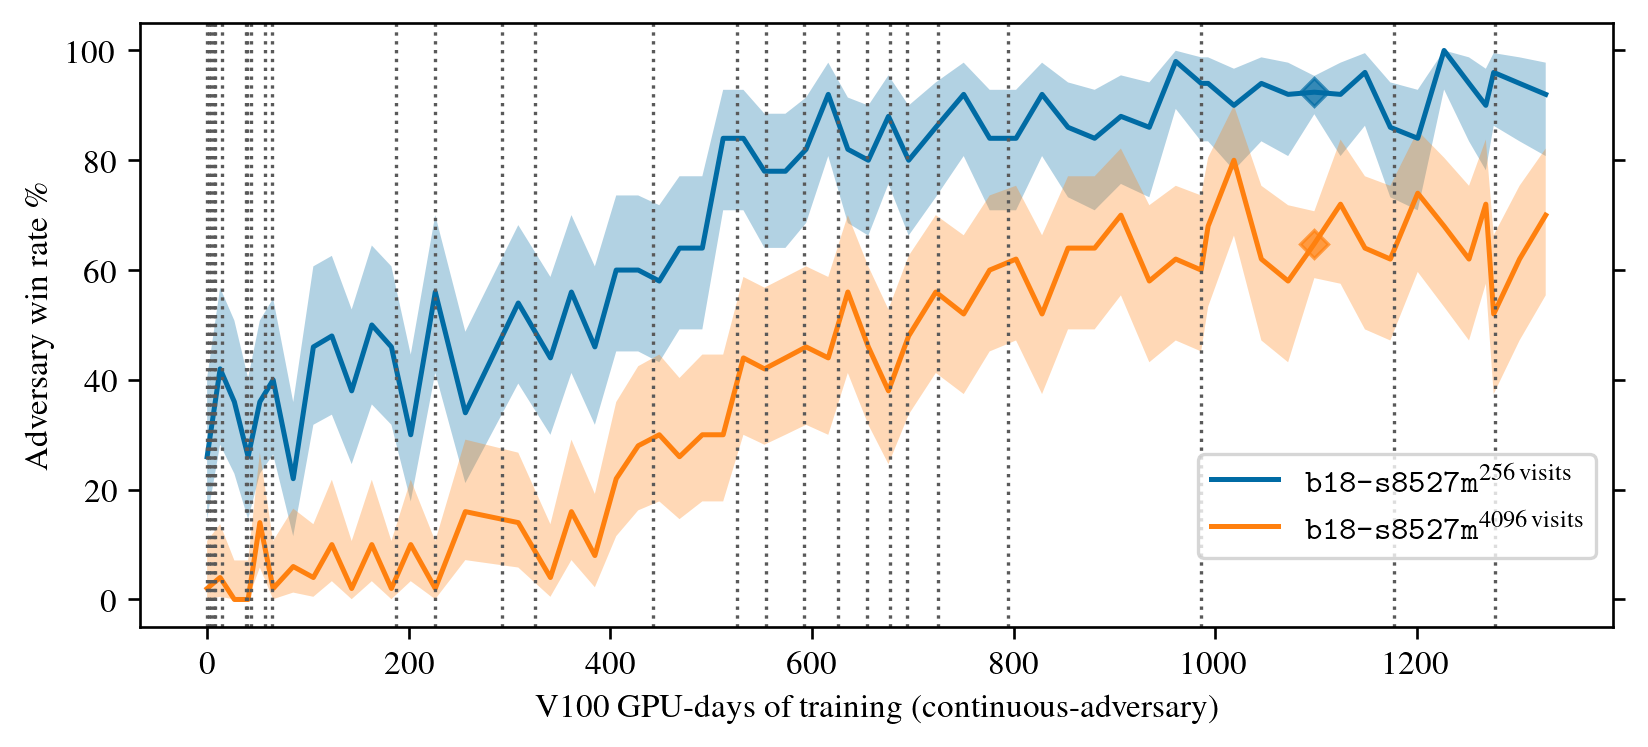

In [7]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-sweeps-240313/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
fig, axs = plot_win_rate_vs_gpu_days(
    df,
    [Path("/shared/victimplay/ttseng-continuous-attack-230823")],
    {
        "b18-s8527m-v256": r"$\texttt{b18-s8527m}^\mathrm{256\,visits}$",
        "b18-s8527m-v4096": r"$\texttt{b18-s8527m}^\mathrm{4096\,visits}$",
    },
    630461952,
    adv_name=r"continuous-adversary",
)
axs.legend(loc="center right", bbox_to_anchor=(1, .2))
fig.savefig("win-rate-vs-gpu-days-continuous.pgf", backend="pgf")

In [ ]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-attack-h9-sweeps-240313/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
fig, axs = plot_win_rate_vs_gpu_days(
    df,
    Path("/shared/victimplay/ttseng-continuous-attack-230823"),
    # ("attack h9", [("ttseng-attack-h9-240119", 89110272), ("ttseng-attack-h9-cont-240124", 20176640), ("ttseng-attack-h9-cont-240126", 494445056), ("ttseng-attack-h9-cont-240229", 46917888), ("ttseng-attack-h9-cont-240305", 2067456)])
    {
        "b18-s8527m-v256": r"$\texttt{b18-s8527m}^\mathrm{256\,visits}$",
        "b18-s8527m-v4096": r"$\texttt{b18-s8527m}^\mathrm{4096\,visits}$",
    },
    630461952,
    adv_name=r"continuous-adversary",
)
axs.legend(loc="center right", bbox_to_anchor=(1, .2))
fig.savefig("win-rate-vs-gpu-days-continuous.pgf", backend="pgf")

Victims: ['cp505h-v4096' 'cp127h-v1' 'cp39h-v1' 'cp505h-v1' 'cp505-v1'
 'cp505-v4096']

(GPU-days, win rate) against cp39h-v1: [(0.66, 0.0), (4.7, 0.0), (8.78, 0.0), (12.86, 100.0), (18.03, 77.08), (22.33, 98.0), (26.92, 100.0), (31.47, 100.0), (35.8, 100.0), (40.7, 100.0), (45.84, 100.0), (51.64, 90.0), (56.78, 94.0), (61.87, 100.0), (66.83, 100.0), (72.09, 100.0), (77.36, 100.0), (84.09, 100.0), (90.78, 96.0), (97.61, 84.62), (112.89, 61.54), (131.97, 40.0), (152.41, 39.58), (175.92, 31.25), (198.37, 36.54), (219.0, 39.58), (239.15, 50.0), (259.12, 40.0), (279.06, 52.0), (299.17, 53.85), (325.38, 58.33), (356.72, 58.0), (386.58, 52.08), (417.16, 40.38), (442.44, 50.0), (464.76, 66.67), (487.25, 72.92), (509.24, 50.0), (532.25, 76.92), (553.32, 54.0), (574.26, 66.0), (595.19, 72.0), (615.39, 62.5), (634.9, 28.0), (656.28, 50.0), (674.59, 60.0), (693.81, 69.23), (712.87, 70.0), (731.35, 72.0), (749.64, 66.0), (781.31, 33.33), (832.09, 30.0), (931.11, 14.58), (1206.19, 22.0), (2223.23, 

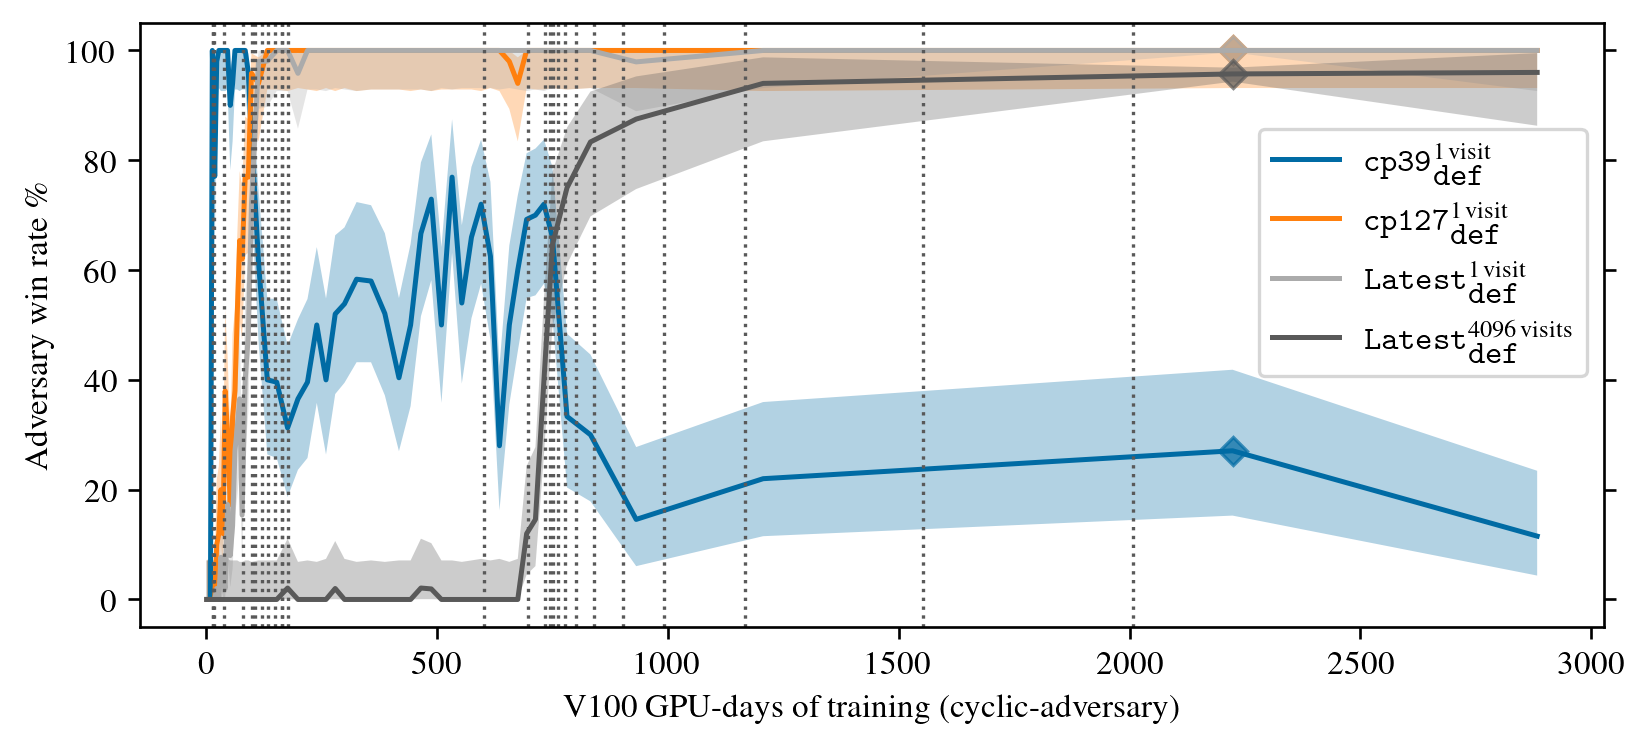

In [10]:
df = utils.parse_sgfs(
    [f"{NAS_DATA}"/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-s545mil-20230117"]
)
print("Victims:", df.victim_name.unique())
fig, axs = plot_win_rate_vs_gpu_days(
    df,
    CYCLIC_ADV_TRAINING_PATH,
    {
        "cp39h-v1": r"$\texttt{cp39}_\texttt{def}^\mathrm{1\,visit}$\;",
        "cp127h-v1": r"$\texttt{cp127}_\texttt{def}^\mathrm{1\,visit}$\;",
        "cp505h-v1": r"$\texttt{Latest}_\texttt{def}^\mathrm{1\,visit}$\;",
        "cp505h-v4096": r"$\texttt{Latest}_\texttt{def}^\mathrm{4096\,visits}$\;",
    },
    CYCLIC_ADV_TRAINING_STEPS,
    adv_name=r"cyclic-adversary",
)
axs.legend(loc="center right", bbox_to_anchor=(1, 0.62))
fig.savefig("win-rate-vs-gpu-days-cyclic.pgf", backend="pgf")

## GPU-days vs. adversary training steps

In [11]:
def plot_gpu_days_vs_steps(
    training_path: Path | list[Path],
    highlighted_point_step: int,
    adv_name: str,
    custom_xlabel: str | None = None,
    custom_ylabel: str | None = None,
    continue_steps: list[int] | None = None,
    victim_change_steps: list[int] | None = None
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes, dict]:
    """
    continue_steps:
        For each training path, the number of steps taken before being
        "continued" by the subsequent training path run.
    """
    def filt_by_cont_steps(xss: list[list[int]]):
        assert continue_steps is not None
        return [
            [x for x in xs if x <= continue_step]
            for xs, continue_step in zip(xss, continue_steps)
        ]

    if isinstance(training_path, list):
        adv_steps_lists = filt_by_cont_steps(
            [get_all_adversary_steps(tp) for tp in training_path]
        )
        gpu_days_lists = [
            get_v100_gpu_days(x, y) for x, y in zip(training_path, adv_steps_lists)
        ]
        assert all(len(x) == len(y) for x, y in zip(adv_steps_lists, gpu_days_lists))

        adv_steps_list = []
        gpu_days_list = []
        for adv_steps, gpu_days in zip(adv_steps_lists, gpu_days_lists):
            print(adv_steps)
            print(gpu_days)
            if len(adv_steps_list) == 0:
                adv_steps_list.extend(adv_steps)
                gpu_days_list.extend(gpu_days)
            else:
                adv_steps_list.extend([adv_steps_list[-1] + x for x in adv_steps[1:]])
                gpu_days_list.extend([gpu_days_list[-1] + x for x in gpu_days[1:]])
    else:
        adv_steps_list = get_all_adversary_steps(training_path)
        gpu_days_list = get_v100_gpu_days(training_path, adv_steps_list)

    assert len(adv_steps_list) == len(gpu_days_list)
    fig, axs = plt.subplots(1, 1)

    if isinstance(training_path, list):
        assert victim_change_steps is not None
    else:
        training_df = utils.parse_sgfs([str(training_path / "selfplay")])
        victim_change_steps = utils.get_victim_change_steps(training_df)

    for xc in victim_change_steps:
        if xc > 0:
            axs.axvline(x=xc, linestyle=":", linewidth=1, color=COLORS[3])

    axs.plot(adv_steps_list, gpu_days_list)
    axs.plot(
        highlighted_point_step,
        gpu_days_list[adv_steps_list.index(highlighted_point_step)],
        "D",
        color=COLORS[0],
        alpha=0.7,
    )
    axs.set_xlabel(custom_xlabel or f"{adv_name}-adversary training steps")
    axs.set_ylabel(custom_ylabel or "V100 GPU-days of training")

    return (
        fig,
        axs,
        dict(
            adv_steps_list=adv_steps_list,
            gpu_days_list=gpu_days_list,
            victim_change_steps=victim_change_steps,
        ),
    )


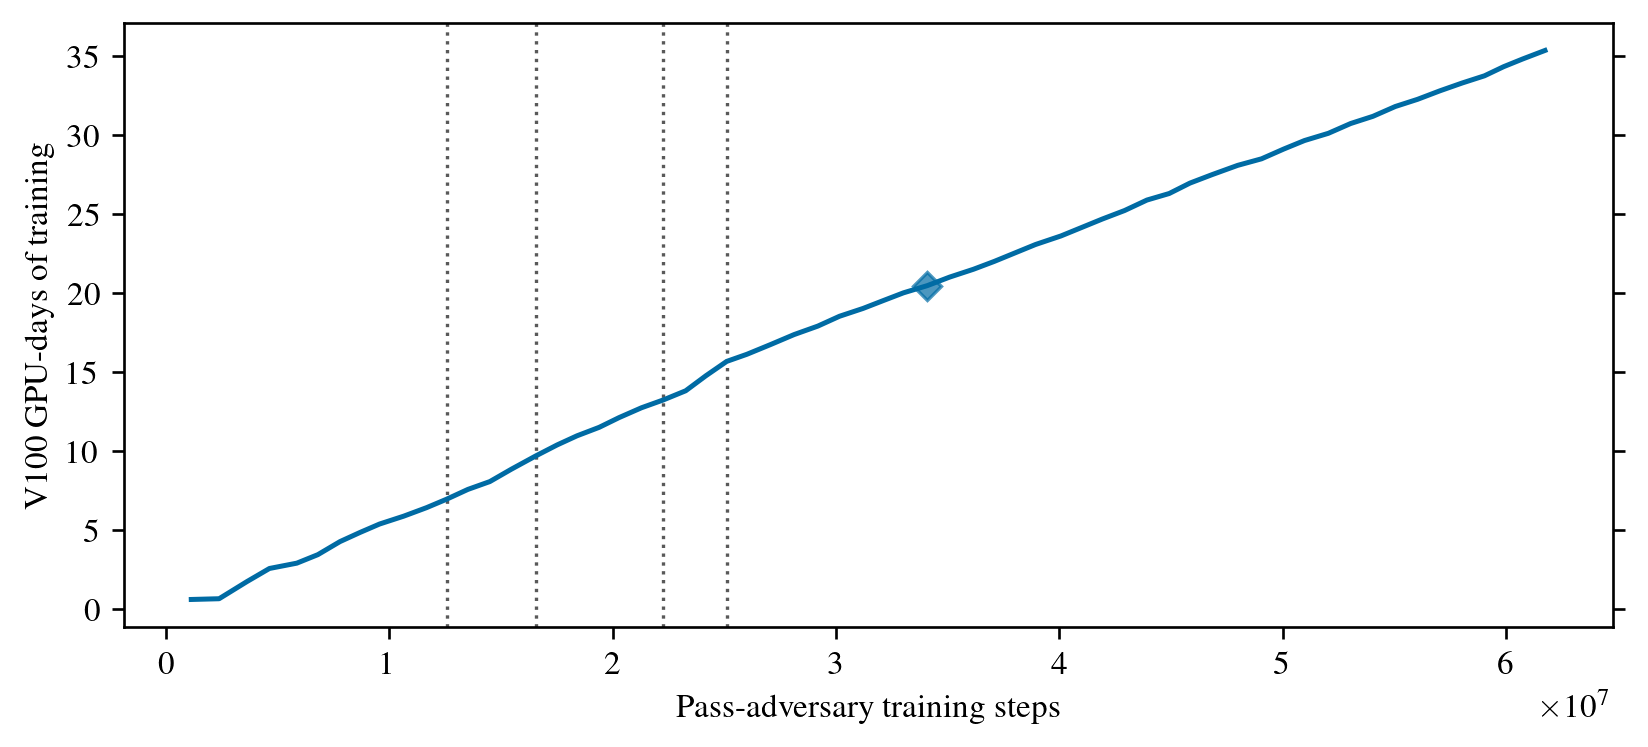

In [12]:
fig, _, _ = plot_gpu_days_vs_steps(
    PASS_ADV_TRAINING_PATH, PASS_ADV_TRAINING_STEPS, adv_name="Pass"
)
fig.savefig("gpu-days-vs-steps-pass.pgf", backend="pgf")

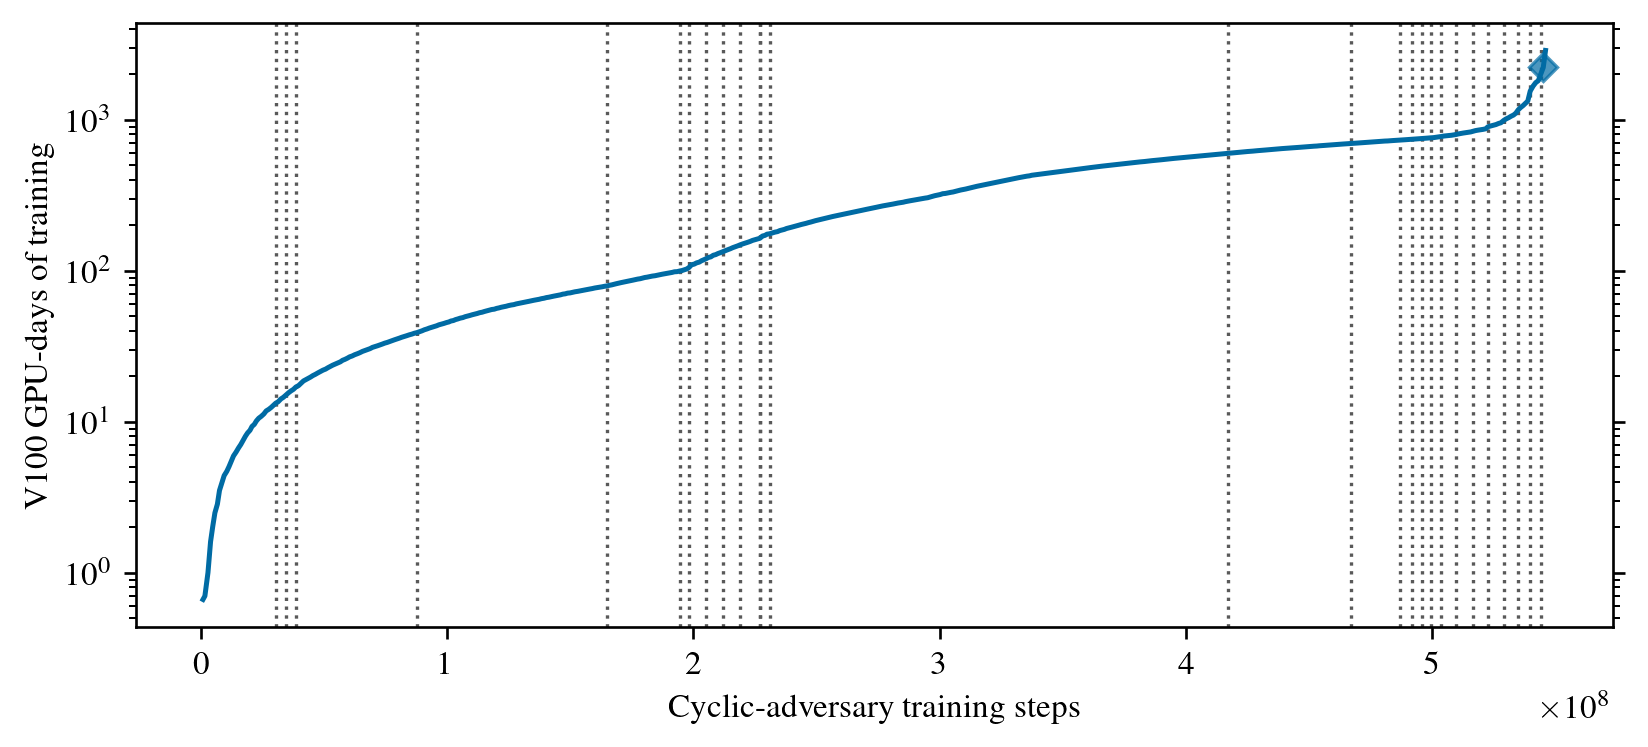

In [13]:
fig, axs, _ = plot_gpu_days_vs_steps(
    CYCLIC_ADV_TRAINING_PATH, CYCLIC_ADV_TRAINING_STEPS, adv_name="Cyclic"
)
axs.set_yscale("log")
fig.savefig("gpu-days-vs-steps-cyclic.pgf", backend="pgf")

### Winrate over course of fine-tuning

In [14]:
df_ft = utils.parse_sgfs(
    [
        f"{NAS_DATA}"/k8/go-attack/match/tony-ft-eval-sweep",
        f"{NAS_DATA}"/k8/go-attack/match/tony-ft-evals-v1.1",
        f"{NAS_DATA}"/k8/go-attack/match/tony-ft-evals-v2",
    ]
)

# cs means cumulative steps (counting all prior steps we are resuming from)
# os means original steps (indexing local to the training run)
# cml = abbreviation for cumulative
df_ft["adv_orig_steps"] = df_ft.adv_name.str.split("-cs").str[0].str.split("-os").str[-1].astype(int)
df_ft["adv_cml_steps"] = df_ft.adv_name.str.split("-cs").str[-1].astype(int)
len(df_ft)

14200

In [15]:
offsets = list(sorted((df_ft.adv_cml_steps - df_ft.adv_orig_steps).unique()))
victim_change_cml_steps = []
for run_dir, offset, drop_left, drop_right in zip(
    [
        "ttseng-cyclic-vs-cp564-20230213-154321",
        "tony-cyc-adv-ft-vs-b60-s7702m-20230518-185923",
        "tony-cyc-adv-ft-vs-b60-s7702m-20230520-174057",
    ],
    offsets,
    [0, 0, 1],
    [0, 2, 0],
):
    tmp_df = utils.parse_sgfs(
        [os.path.join(f"{NAS_DATA}"/k8/go-attack/victimplay", run_dir, "selfplay")]
    )
    victim_visits = list(sorted(tmp_df.victim_visits.unique()))
    drop_visits = victim_visits[drop_left : len(victim_visits) - drop_right]
    print("Unique victim visits", victim_visits)
    print("Dropped victim visits", drop_visits)

    steps = utils.get_victim_change_steps(tmp_df)

    # Here we drop steps that are:
    #   - duplicated: this happens when we resume training run using the exact
    #     same settings that we left off with.
    #   - not used by future training runs: this happens when we resume a
    #     training run but not from the last generated checkpoint.    
    drop_steps = steps[drop_left : len(steps) - drop_right]
    print("Steps", steps)
    print("Dropped steps", drop_steps)

    assert len(steps) == len(victim_visits)
    assert len(drop_steps) == len(drop_visits)

    victim_change_cml_steps.extend(
        [s + offset for s in drop_steps]
    )

print(victim_change_cml_steps)

Unique victim visits [32, 128, 512, 1600]
Dropped victim visits [32, 128, 512, 1600]
Steps [0, 8558080, 12211200, 16155392]
Dropped steps [0, 8558080, 12211200, 16155392]
Unique victim visits [32, 64, 128]
Dropped victim visits [32]
Steps [0, 26985728, 34275840]
Dropped steps [0]
Unique victim visits [64, 128, 256, 512, 1024, 2048, 4096]
Dropped victim visits [128, 256, 512, 1024, 2048, 4096]
Steps [0, 1600256, 22809344, 75567360, 87401472, 96528896, 105302272]
Dropped steps [1600256, 22809344, 75567360, 87401472, 96528896, 105302272]
[0, 8558080, 12211200, 16155392, 22887680, 58763776, 79972864, 132730880, 144564992, 153692416, 162465792]


[('ttseng-cyclic-vs-cp564-20230213-154321', 22887680), ('tony-cyc-adv-ft-vs-b60-s7702m-20230518-185923', 34275840), ('tony-cyc-adv-ft-vs-b60-s7702m-20230520-174057', 111218432)]
168381952
[0, 752128, 1503744, 2485248, 3729664, 4523264, 5681152, 6660352, 7558400, 8558080, 9384448, 10338048, 11326208, 12211200, 13283840, 14328832, 15258112, 16155392, 17159168, 18127872, 19129344, 20100352, 20922624, 21827328, 22887680]
[0.0, 4.871011272886107, 4.90633854936117, 7.416673742956825, 14.63647773258155, 17.0897823319812, 19.002197870711836, 21.764223382633553, 24.825529240393827, 26.98494963674599, 29.538998109253644, 33.25670882224453, 35.51537345651683, 38.72798679291544, 41.99516434952241, 46.470868366804396, 52.04820686889025, 55.008313402469604, 61.29371148191948, 72.20366894074974, 82.36108378567627, 95.33660469448037, 104.38090361107416, 114.5845681204593, 124.03995958589618]
[0, 850176, 1699328, 2720512, 3789312, 4786432, 5760512, 6628096, 7588608, 8646400, 9601280, 10530048, 11507200

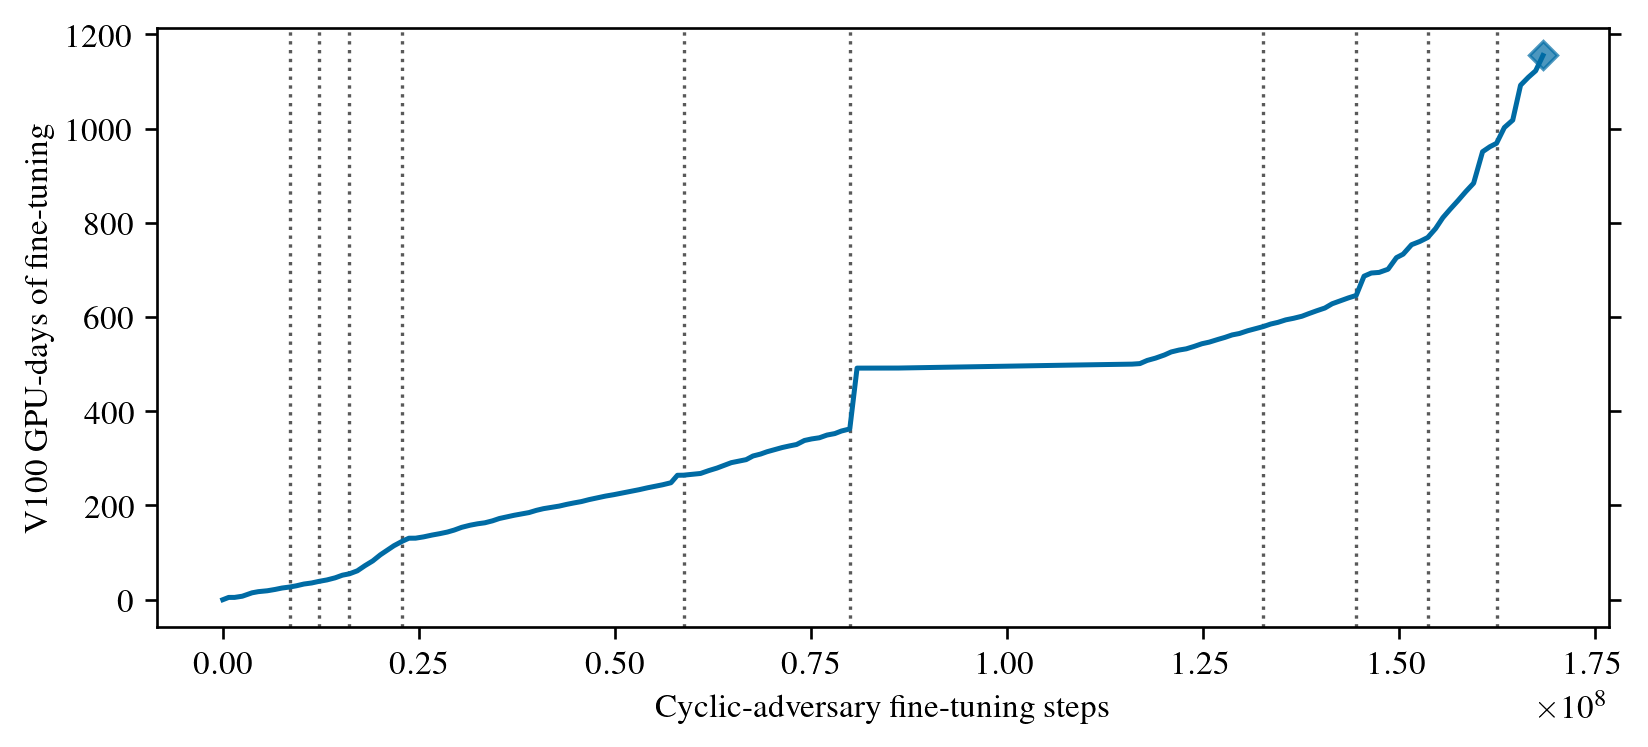

In [16]:
print(FINETUNING_ADV_PATHS)
print(sum(x[1] for x in FINETUNING_ADV_PATHS))

fig, _, ft_dict = plot_gpu_days_vs_steps(
    [Path(f"{NAS_DATA}"/k8/go-attack/victimplay/" + x[0]) for x in FINETUNING_ADV_PATHS],
    highlighted_point_step=sum(x[1] for x in FINETUNING_ADV_PATHS),
    adv_name="Fine-tuned-cyclic",
    custom_xlabel="Cyclic-adversary fine-tuning steps",
    custom_ylabel="V100 GPU-days of fine-tuning",
    continue_steps=[x[1] for x in FINETUNING_ADV_PATHS],
    victim_change_steps=victim_change_cml_steps,
)
fig.savefig("gpu-days-vs-steps-fine-tune.pgf", backend="pgf")

# The big jump at around around 0.75e8 steps below is when the shuffler died. 

168381952
168381952


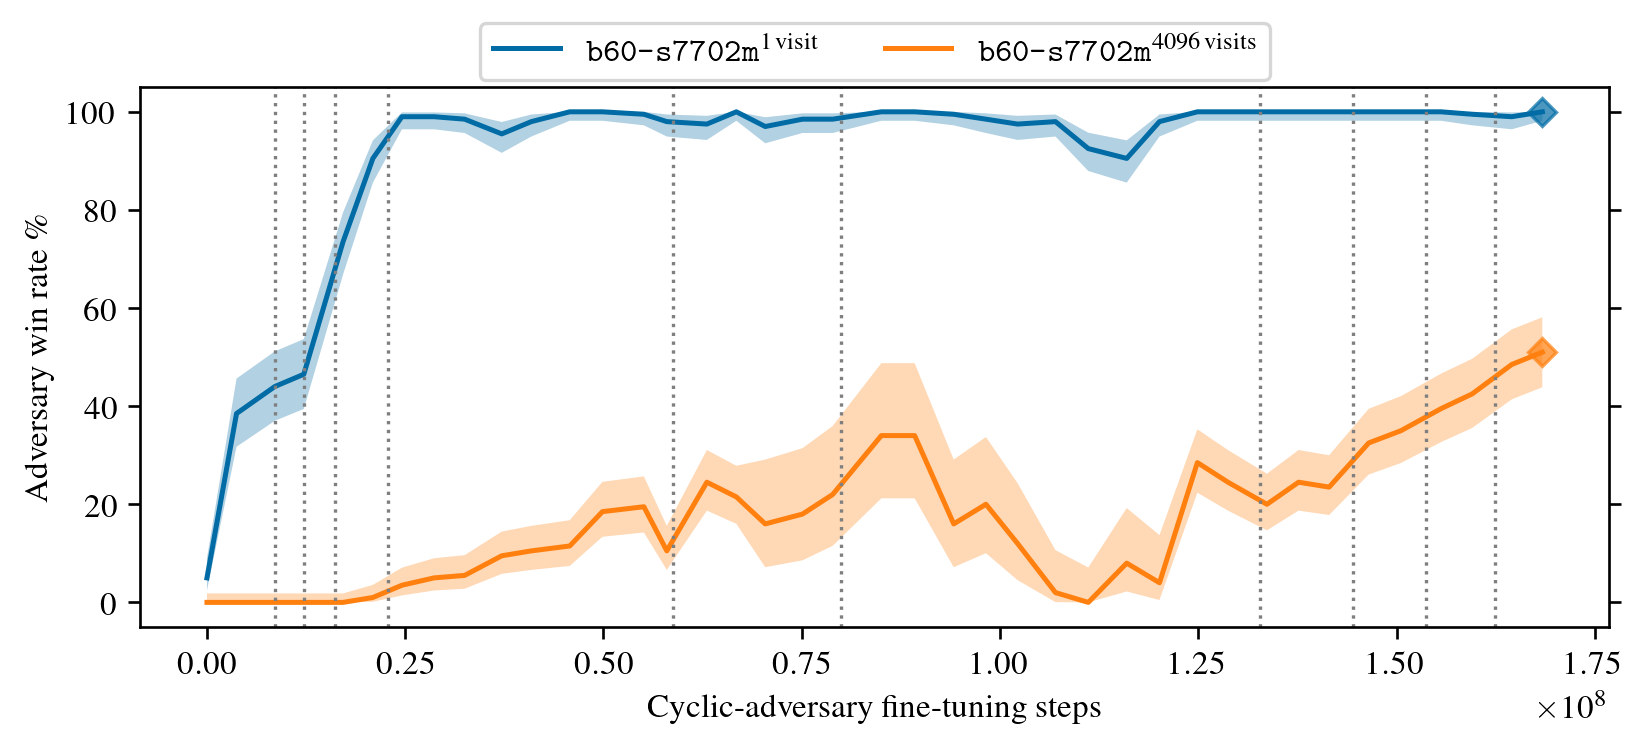

In [17]:
ALPHA = 0.05

for victim_visits in [1, 4096]:
    sub_df = df_ft.query("victim_visits == @victim_visits")

    mean_df = sub_df.groupby("adv_cml_steps").adv_win.mean()
    visit_suffix = r"visits\;\;" if victim_visits > 1 else "visit"
    (100 * mean_df).plot(
        label=rf"$\texttt{{b60-s7702m}}^\mathrm{{{victim_visits}\,{visit_suffix}}}$",
    )

    # Compute Clopper-Pearson confidence intervals
    ci_df = sub_df.groupby("adv_cml_steps").adv_win.apply(
        lambda x: proportion_confint(
            x.sum(),
            len(x),
            alpha=ALPHA,
            method="beta",
        )
    )
    ci_df = pd.DataFrame(ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"])
    ci_df = 100 * ci_df
    plt.fill_between(
        mean_df.index,
        ci_df.lower,  # type: ignore
        ci_df.upper,  # type: ignore
        alpha=0.3,
        edgecolor="none",
    )

    plt.plot(
        mean_df.index[-1],
        100 * mean_df.iloc[-1],
        "D",
        # Use same color as line
        color=plt.gca().lines[-1].get_color(),
        alpha=0.7,
    )
    print(mean_df.index[-1])

max_step = max(victim_change_cml_steps)
for xc in victim_change_cml_steps:
    if xc > 0:
        plt.axvline(x=xc, linestyle=":", linewidth=1, color="tab:gray")

plt.xlabel("Cyclic-adversary fine-tuning steps")
plt.ylabel(r"Adversary win rate \%")

# Legend on top of plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.ylim(-5, 105)
plt.savefig(f"adv-fine-tune-vs-steps.pgf", backend="pgf")
plt.show()

Possible extension to above plot would be to show winrate against Latest-v4096.
This demonstrates that our current attack strategy
suffers from catastrophic forgetting, not sure this is core to the paper though.
Also we already have an eval that demonstrates this.

In [18]:
assert ft_dict["victim_change_steps"] == victim_change_cml_steps

victim_change_cml_gpu_days = []
for step in victim_change_cml_steps:
    idx = ft_dict["adv_steps_list"].index(step)
    victim_change_cml_gpu_days.append(ft_dict["gpu_days_list"][idx])

print(victim_change_cml_gpu_days)

[0.0, 26.98494963674599, 38.72798679291544, 55.008313402469604, 124.03995958589618, 264.2679141299433, 362.4313652058573, 579.7242703574045, 645.7236039975526, 768.7375005042735, 968.5768504243815]


168381952
168381952


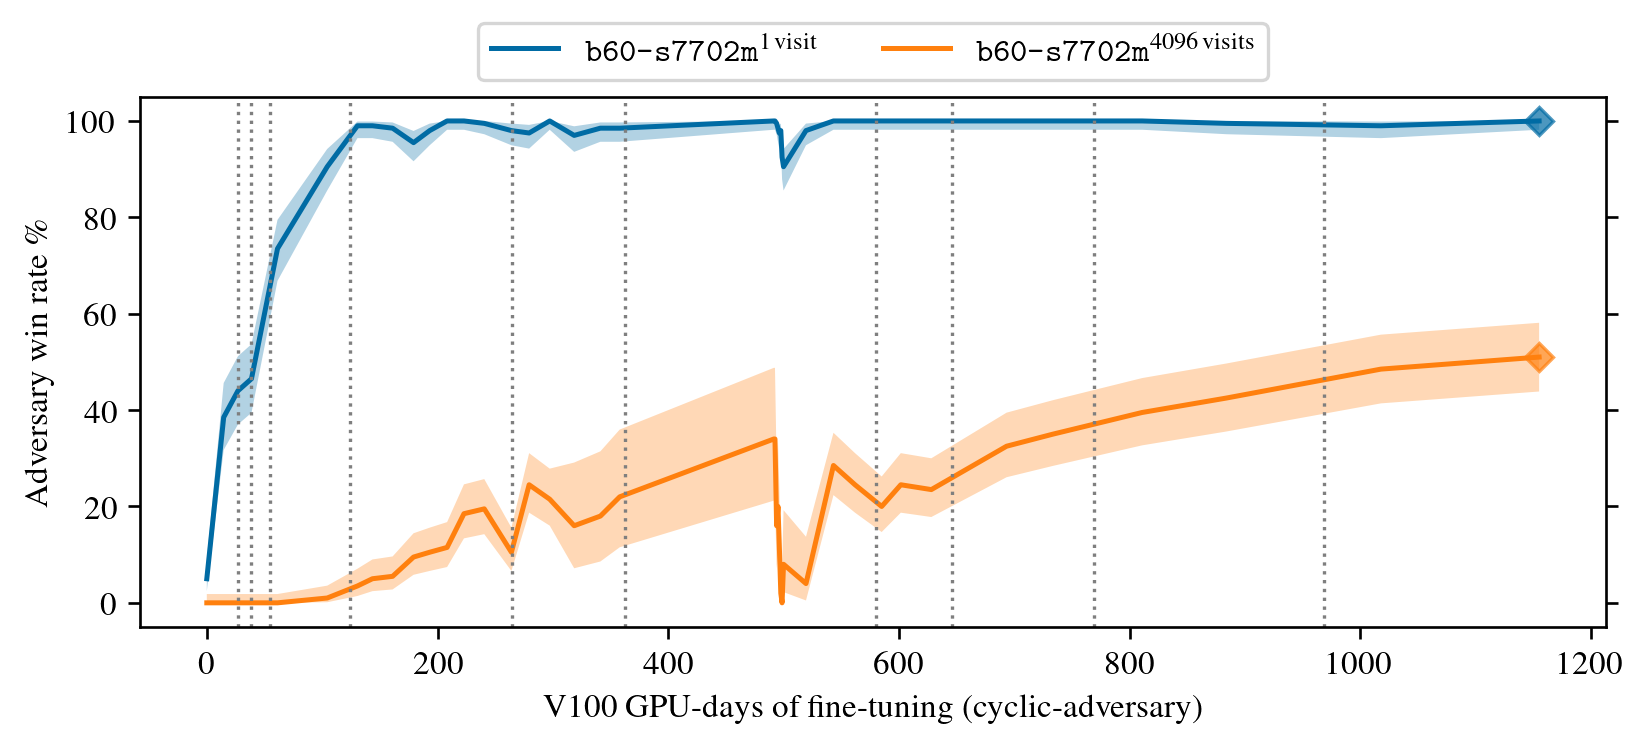

168381952
168381952


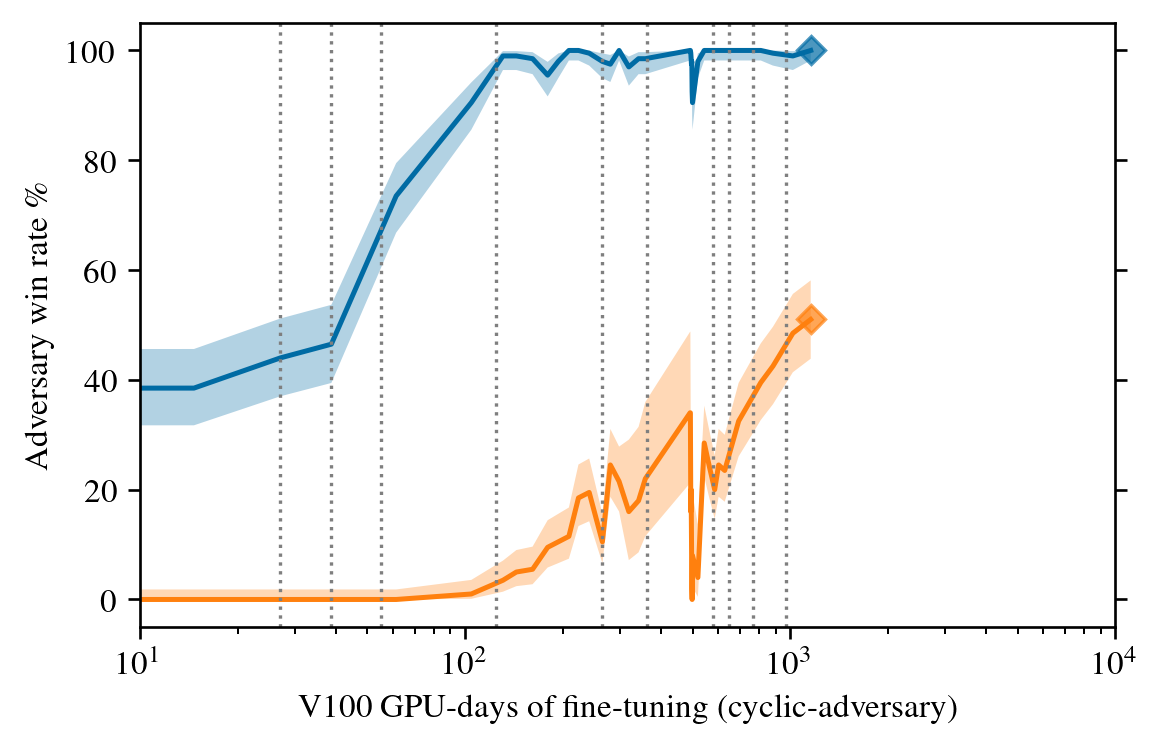

In [19]:
def ft_adv_gpu_day_plot():
    ALPHA = 0.05

    for victim_visits in [1, 4096]:
        sub_df = df_ft.query("victim_visits == @victim_visits")

        mean_df = sub_df.groupby("adv_cml_steps").adv_win.mean()
        index_gpu_days = [
            ft_dict["gpu_days_list"][ft_dict["adv_steps_list"].index(s)]
            for s in mean_df.index
        ]

        visit_suffix = r"visits\;\;" if victim_visits > 1 else "visit"
        plt.plot(
            index_gpu_days,
            100 * mean_df,
            label=rf"$\texttt{{b60-s7702m}}^\mathrm{{{victim_visits}\,{visit_suffix}}}$",
        )

        # Compute Clopper-Pearson confidence intervals
        ci_df = sub_df.groupby("adv_cml_steps").adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"])
        ci_df = 100 * ci_df
        plt.fill_between(
            index_gpu_days,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            edgecolor="none",
        )

        plt.plot(
            index_gpu_days[-1],
            100 * mean_df.iloc[-1],
            "D",
            # Use same color as line
            color=plt.gca().lines[-1].get_color(),
            alpha=0.7,
        )
        print(mean_df.index[-1])

    for xc in victim_change_cml_gpu_days:
        if xc > 0:
            plt.axvline(x=xc, linestyle=":", linewidth=1, color="tab:gray")

    plt.xlabel("V100 GPU-days of fine-tuning (cyclic-adversary)")
    plt.ylabel(r"Adversary win rate \%")

    plt.ylim(-5, 105)

ft_adv_gpu_day_plot()
# Legend on top of plot
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)
plt.savefig(f"adv-fine-tune-vs-gpu-days.pgf", backend="pgf")
plt.show()

ft_adv_gpu_day_plot()
plt.xscale("log")
plt.xlim(10, 10000)

# Add in a linear interpolation line
xs = np.linspace(1000, 3e4, 1000)
ys = np.log10(xs) * 70 - 163
# plt.plot(xs, ys, linestyle="--", linewidth=1, color="black", zorder=-10)

plt.gcf().set_figwidth(plt.gcf().get_figwidth() * 0.7)
plt.savefig(f"adv-fine-tune-vs-gpu-days-log.pgf", backend="pgf")
plt.show()

168381952
168381952


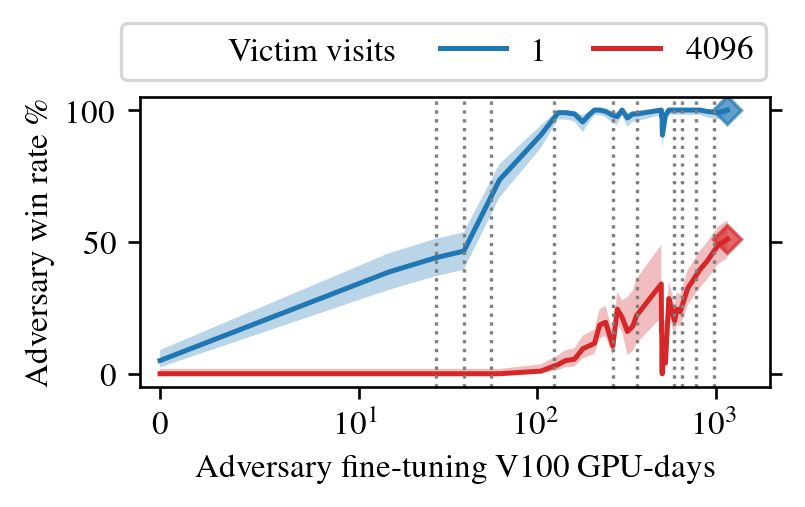

In [20]:
tmp_plot_style = [
    "tableau-colorblind10",
    utils.get_style("default"),
    utils.get_style("2-col"),
    {
        "ytick.left": True,
        "ytick.right": True,
    }
]

with plt.style.context(tmp_plot_style):
    # Set color cycle to custom colors, blue and red
    plt.gca().set_prop_cycle(
        cycler(
            "color",
            [
                "tab:blue",
                "tab:red",
            ],
        )
    )
    ft_adv_gpu_day_plot()

    # Dummy orange line for legend
    plt.scatter([], [], color="tab:orange", label="dummy", alpha=0,)
    handles, _ = plt.gca().get_legend_handles_labels()

    # Custom legend
    plt.legend(
        [handles[2], handles[0], handles[1]],
        [r"$\hspace{-1cm}$ Victim visits", "1", "4096"],
        loc="lower right",
        bbox_to_anchor=(1.02, 1),
        ncols=3,
        columnspacing=1.3,
    )

    plt.xlabel("Adversary fine-tuning V100 GPU-days")
    plt.xscale("symlog", linthresh=10)
    plt.xlim(-1, 2000)

    plt.savefig(f"adv-fine-tune-vs-gpu-days-log-2col.pgf", backend="pgf", transparent=True)
    plt.show()

168381952
168381952


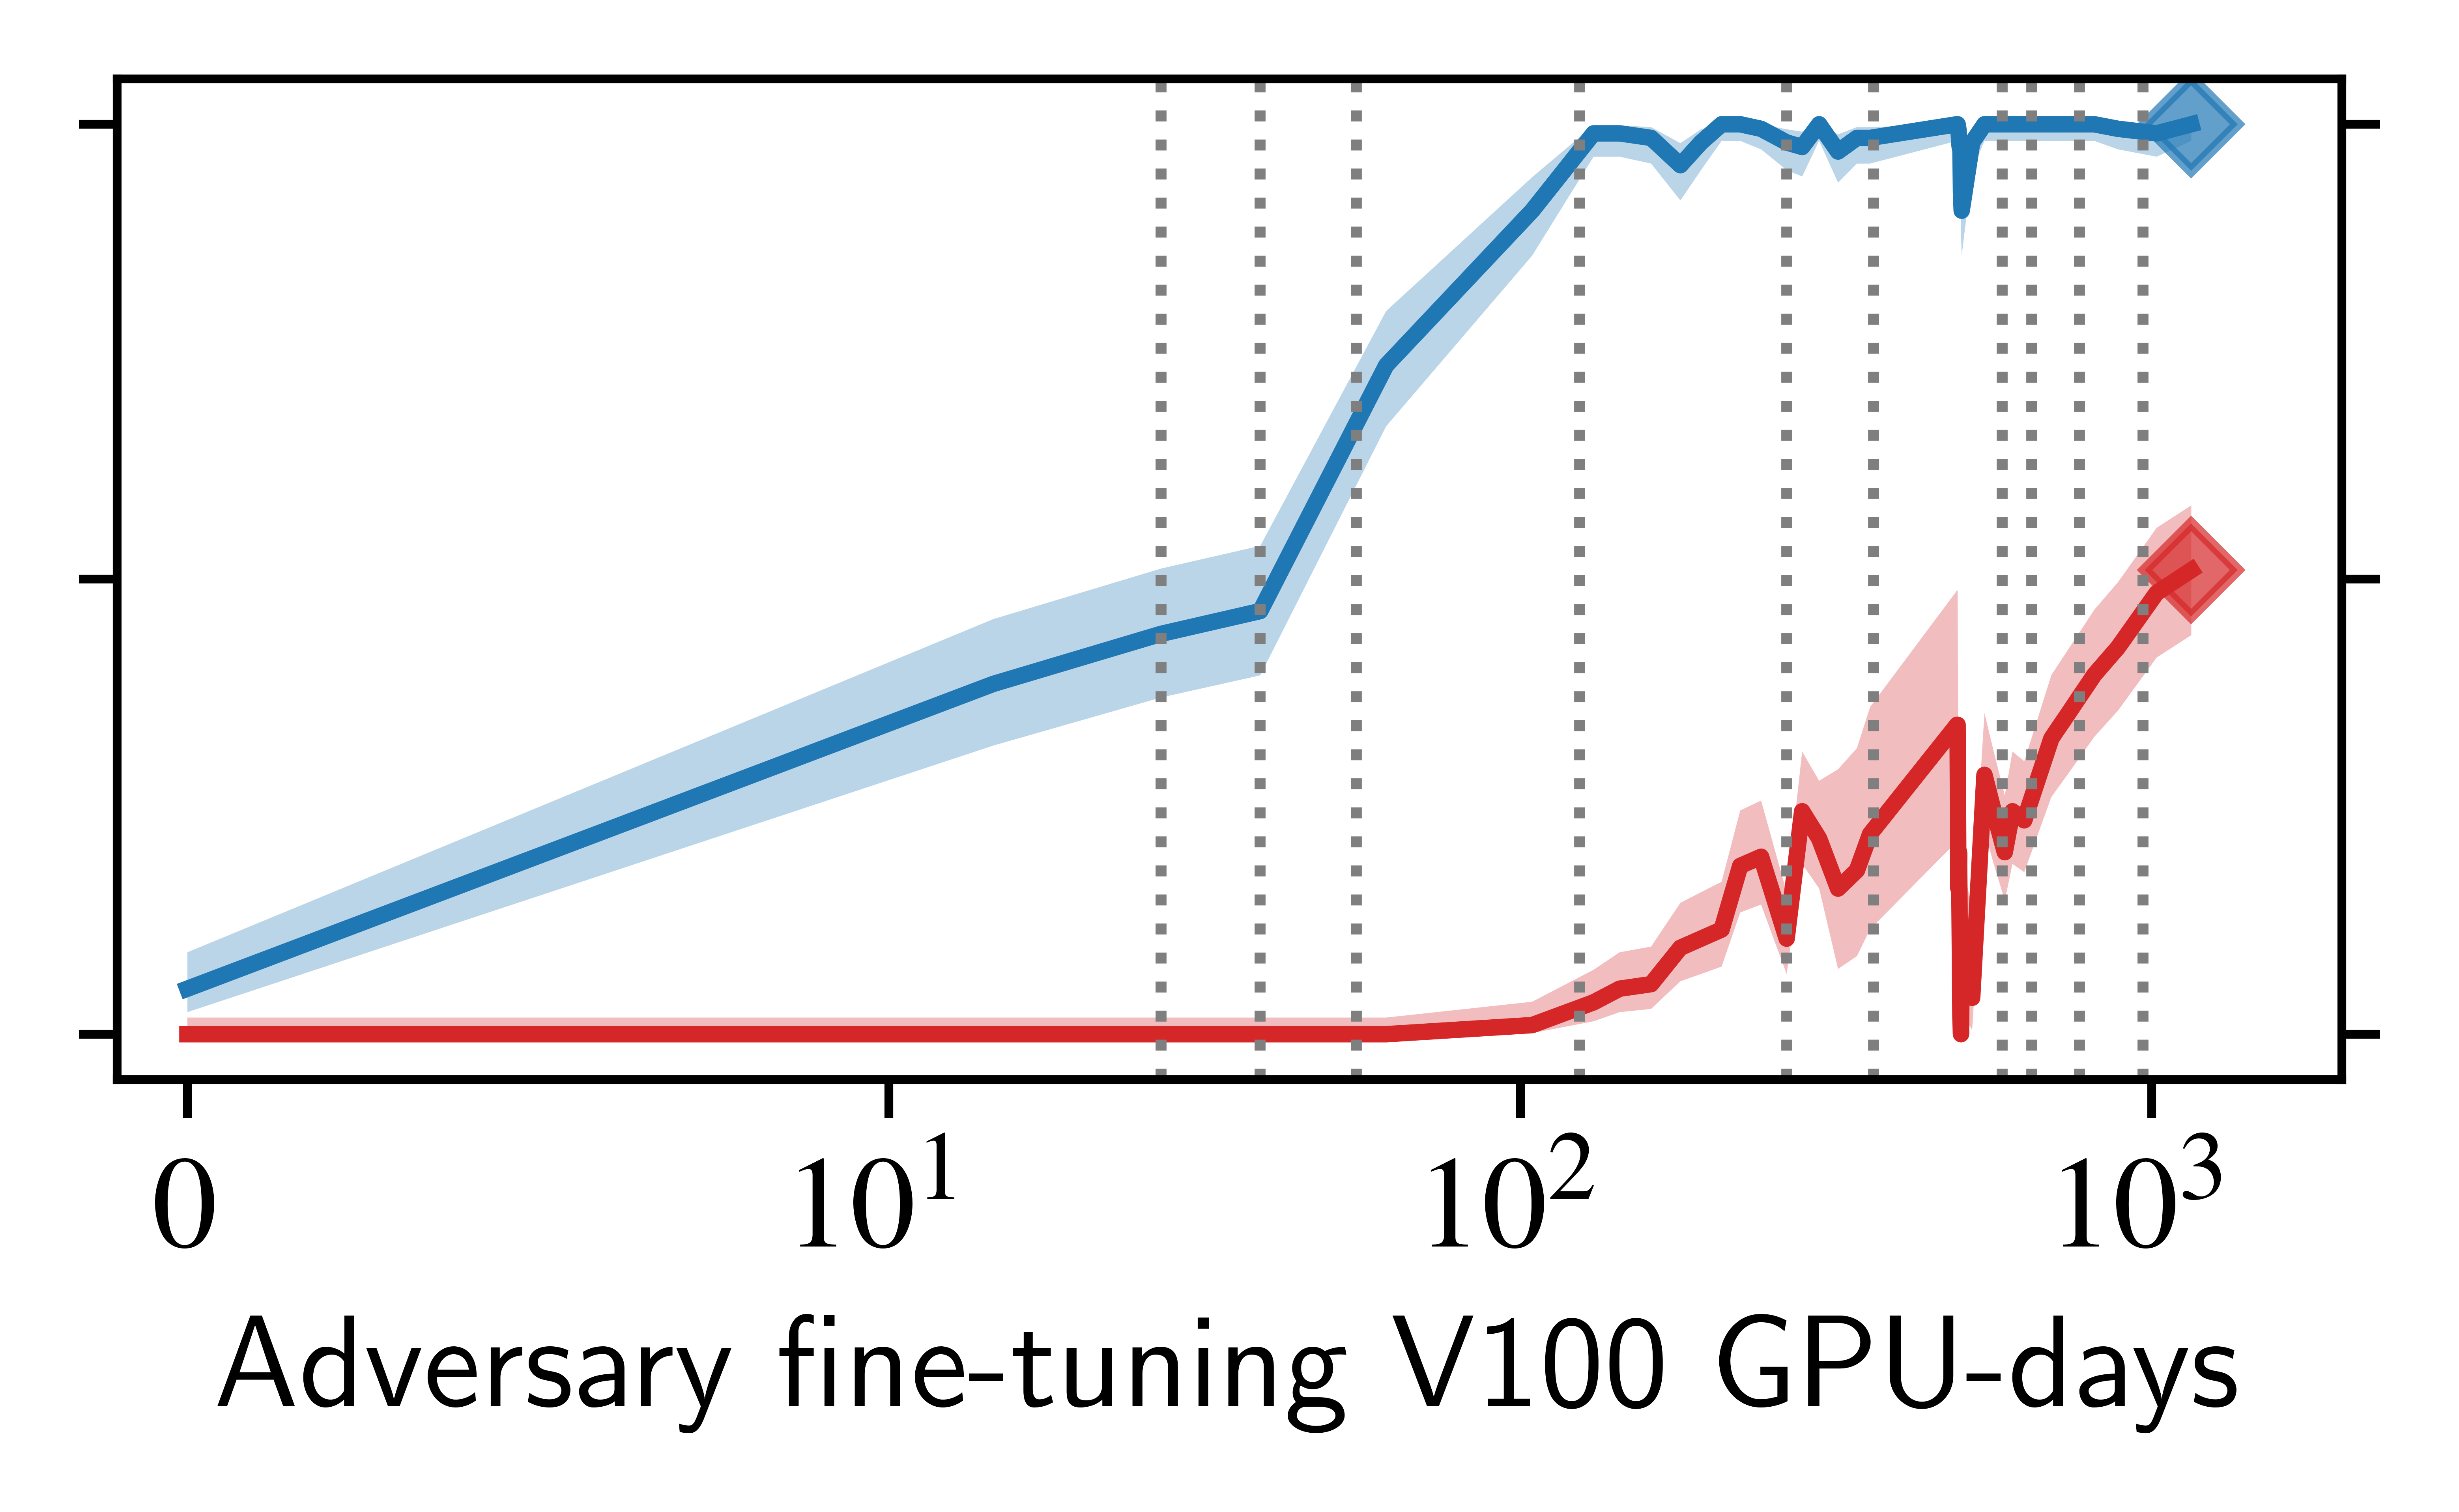

168381952
168381952


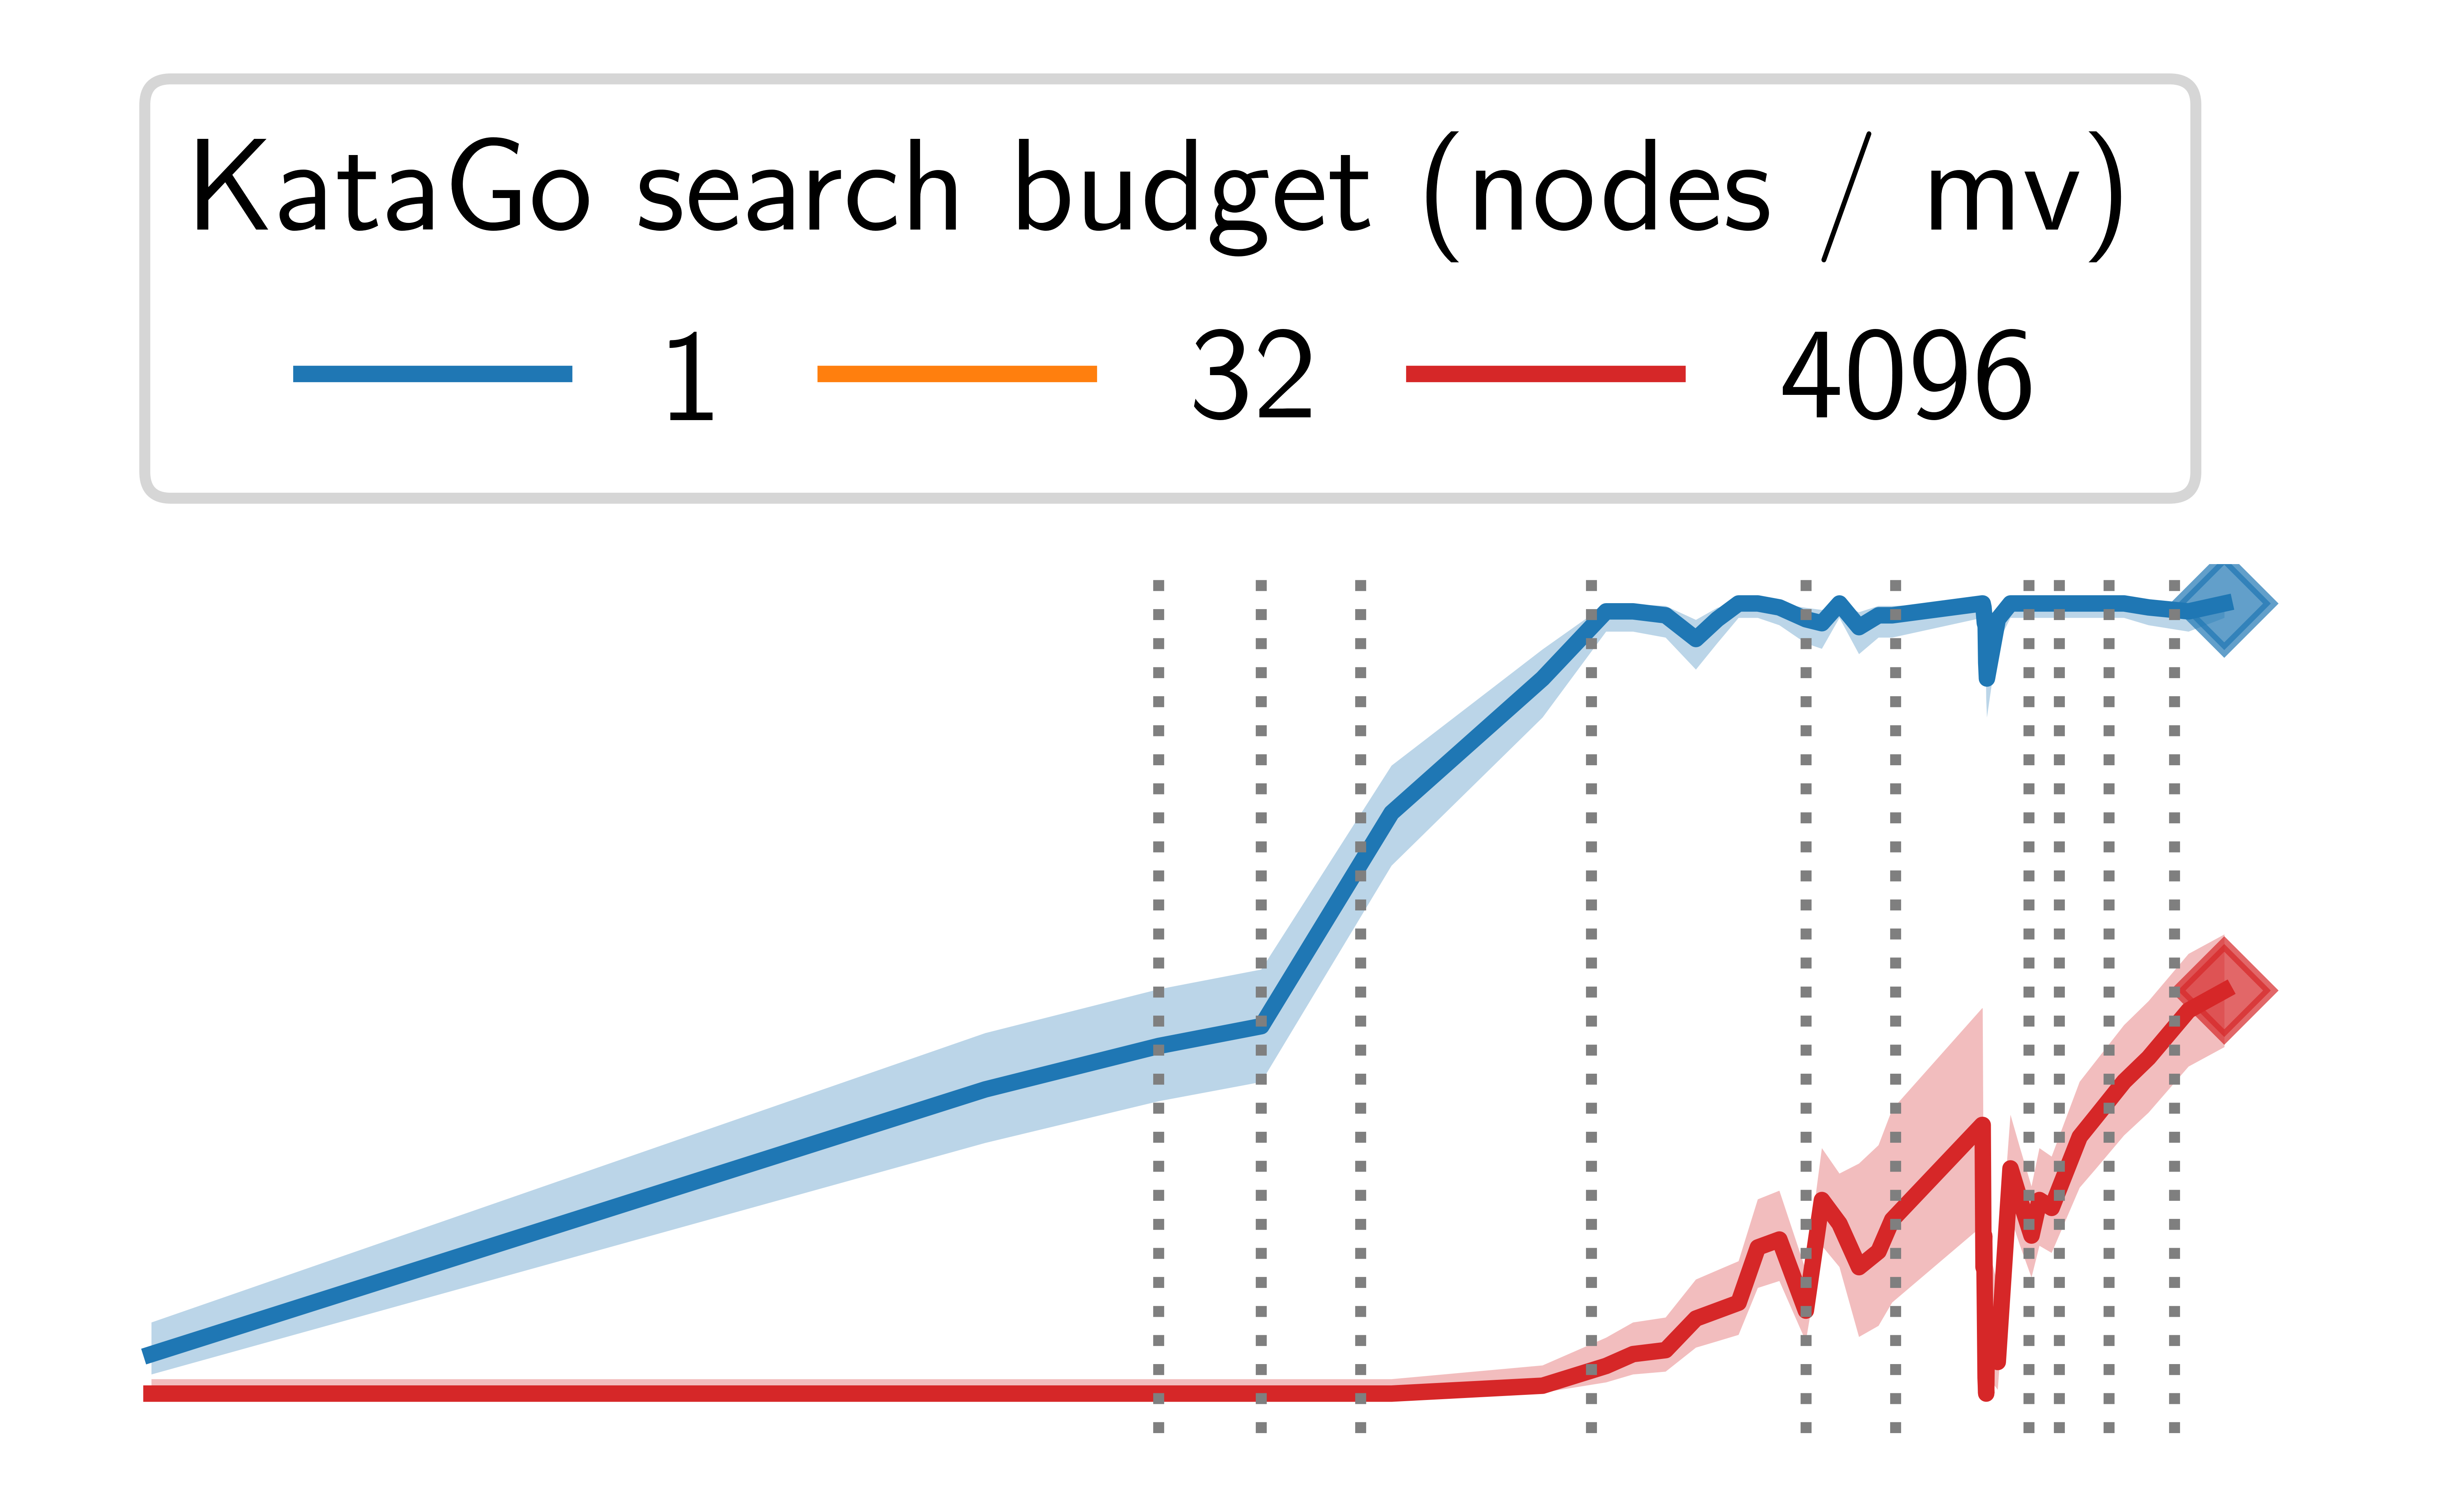

In [21]:
# Poster version of the above plot
tmp_plot_style = [
    "tableau-colorblind10",
    utils.get_style("poster"),
    {
        "ytick.left": True,
        "ytick.right": True
    }
]

for i in range(2):
    with plt.style.context(tmp_plot_style):
        plt.figure(figsize=(3, 1.8), dpi=2000)

        # Set color cycle to custom colors, blue and red
        plt.gca().set_prop_cycle(
            cycler(
                "color",
                [
                    "tab:blue",
                    "tab:red",
                ],
            )
        )

        ft_adv_gpu_day_plot()
        plt.xlabel("Adversary fine-tuning V100 GPU-days")
        plt.ylabel(None)
        plt.xscale("symlog", linthresh=10)
        plt.xlim(-1, 2000)

        # No y-axis numbers
        plt.gca().set_yticklabels([])

        # Dummy orange line for legend
        plt.plot([], [], color="tab:orange", label="32 visits")

        if i == 1:
            # This is for the legend
            handles, labels = plt.gca().get_legend_handles_labels()
            plt.legend(
                [handles[0], handles[2], handles[1]],
                ["1", "32", "4096"],
                loc="lower left",
                bbox_to_anchor=(0, 1),
                ncols=3,
                columnspacing=0.7,
                title=r"KataGo search budget (nodes / mv)",
            )
            plt.gca().set_axis_off()

        # Save as svg
        plt.savefig(f"adv-fine-tune-vs-gpu-days-log-poster-{i}.svg", backend="svg")
        plt.show()